Code to read survey results

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

Data Reading and Preparation:

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

import sys
import json
# Add the parent directory to the path
sys.path.append('..')

# Now you can import the config module
from config import groqkey, OPENAI_Key

In [2]:
def read_ods(filename):
    # Use pandas to read the ODS file. The `engine='odf'` parameter is necessary to read ODS files.
    # Adjust the `sheet_name` parameter as needed. By default, it reads the first sheet.
    df = pd.read_excel(filename, engine='odf')
    return df

# Define a function to replace "not numbered" with the value in "Variable Label"
def replace_not_numbered(row):
    if row["Question number\n (Questionnaire file)"] == "not numbered":
        return row["Variable Label\n (Data files)"]
    else:
        return row["Question number\n (Questionnaire file)"]

In [100]:
# Replace 'example.ods' with the path to your ODS file
filename = 'dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_map.ods'

# Read the ODS file
metaInfo = read_ods(filename)

# Initialize empty lists to store grouped response options
question_numbers = []
variable_labels = []
descriptions = []
response_options = []

# Loop through DataFrame rows
current_question = None
for index, row in metaInfo.iterrows():
    if not pd.isnull(row['Question number(Questionnaire file)']):
        # If it's a new question, store its details
        current_question = row['Question number(Questionnaire file)']
        question_numbers.append(row['Question number(Questionnaire file)'])
        variable_labels.append(row['Variable Label(Data files)'])
        descriptions.append(row['Description'])
        response_options.append([(row['Values'], row['Value labels'])])
    elif current_question is not None:
        # If it's a response option, add it to the previous question's response options
        response_options[-1].append((row['Values'], row['Value labels']))

# Create a new DataFrame with grouped response options
grouped_df = pd.DataFrame({
    'Question number(Questionnaire file)': question_numbers,
    'Variable Label(Data files)': variable_labels,
    'Description': descriptions,
    'Response Options': response_options
})

grouped_df

,Question number(Questionnaire file),Variable Label(Data files),Description,Response Options
0,ID,ID,Respondent ID to match respondents between waves,"[(nan, nan)]"
1,not numbered,Q0_age,Age,"[(1.0, 16-24), (2.0, 25-34), (3.0, 35-44), (4...."
2,not numbered,Q0_gender,What gender do you identify with?,"[(1.0, Male), (2.0, Female)]"
3,not numbered,Q0_race_US,What race do you self-identify as? (USA only),"[(1.0, White), (2.0, Black or African American..."
4,not numbered,Q0_ethnicity_ID,What ethnic group do you identify as? (Indones...,"[(1.0, Jawa), (2.0, Sunda), (3.0, Madura), (4...."
...,...,...,...,...
214,Q60,Q60_elder,Yes – adults over 70,"[(0.0, No), (1.0, Yes)]"
215,Q60,Q60_no,No,"[(0.0, No), (1.0, Yes)]"
216,Q60,Q60_not_say,Prefer not to say,"[(0.0, No), (1.0, Yes)]"
217,Q60a,Q60a_parent,Are you the parent or guardian of any children...,"[(0.0, No), (1.0, Yes)]"


In [4]:
#Wave 1 - All data of NL
Survey_Responses = pd.read_csv("dataverse_files\SCALAR_Coastal_Longitudinal_Study_Wave_One_NL.csv").set_index("ID")

In [5]:
Survey_Overview  = pd.read_excel('Survey Questions Overview.xlsx', sheet_name='Wave 1', engine='openpyxl')
# Clean the survey questions dataframe to make it more usable for mapping
# Fill forward non-null ADICO Category values to apply them to all relevant rows, Specify the columns to forward fill excluding "Values" and "Value labels"
columns_to_ffill = [col for col in Survey_Overview.columns if col not in ["Values", "Value labels"]]

# Forward fill the specified columns
Survey_Overview[columns_to_ffill] = Survey_Overview[columns_to_ffill].ffill()
Survey_Overview = Survey_Overview.rename(columns={'ADICO Category': 'ADICO_Category'})

# Apply the function to replace "not numbered" with the value in "Variable Label"
Survey_Overview["Question number\n (Questionnaire file)"] = Survey_Overview.apply(replace_not_numbered, axis=1)
Survey_Overview['Value labels'] = Survey_Overview['Value labels'].astype(str)

# Set the index to {value of "Question number\n (Questionnaire file)"} + "_" + {str(value of "Values")}
Survey_Overview.set_index(Survey_Overview["Variable Label\n (Data files)"] + "_" + Survey_Overview["Values"].astype(str), inplace=True)
Survey_Overview.drop("ID_nan", inplace=True)
Survey_Overview.drop_duplicates(inplace=True)

question_answers_list = []
# Define a function to create the combined string
def combine_description_and_labels(group, question_answers_list, qnum):
    question_subset = Survey_Overview[Survey_Overview["Question number\n (Questionnaire file)"] == group["Question number\n (Questionnaire file)"].iloc[0]]
    # Check if it's the first row instance with the current "Question number\n (Questionnaire file)" column value
    first_instance_index = question_subset[question_subset.duplicated(subset=["Question number\n (Questionnaire file)"], keep="first")].index
    combined_string = ""
    # Concatenate the current row's "Description" and all "Value labels" values
    combined_string += str(group["Description"].iloc[0]) + ", " #+ "; ".join(group["Value labels"].astype(str))
    
    if first_instance_index.size != 0:
        first_description = question_subset["Description"].iloc[0]
        if first_description != group["Description"].iloc[0]:
         # If not the first instance, start with the first instance's "Description" column value
            combined_string += first_description

    question_answers_list = question_answers_list + [combined_string] * group.shape[0]  # Extend the list with the combined strings
    return question_answers_list

# Group by "Variable Label\n (Data files)" and apply the function to create the combined string
for group in Survey_Overview.groupby("Variable Label\n (Data files)",sort=False):
    question_answers_list = combine_description_and_labels(group[1], question_answers_list, group[1]["Question number\n (Questionnaire file)"].iloc[0])
Survey_Overview["question_answers_combined"] = question_answers_list


# Since the dataset has multiple rows per question for different value labels, we'll create a unique mapping
# Create the new mapping dictionary
question_adico_mapping = Survey_Overview[['question_answers_combined','ADICO_Category',"Variable Label\n (Data files)"]].drop_duplicates().set_index('question_answers_combined')

# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = list(set([Attribute for Attribute in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Conditions = list(set([Condition for Condition in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Aims = list(set([Aim for Aim in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Aim", "Aim/Condition"])]['Variable Label\n (Data files)']]))
Attcons = list(set([Attcon for Attcon in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))

c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Decision tree question selection:

In [98]:
#Selected attributes, aims, and conditions we would like to explore and test 
chosen_aims =  [
    "R2_implementation_SM1",
    "R2_implementation_SM2",
    "R2_implementation_SM3",
    "R2_implementation_SM6",
    "R2_implementation_NM4",
    "R2_implementation_NM2",
    "R2_implementation_NM3"
]
base_conditions = [
    # "R05_worry",
    # "Q0_age",
]
efficacy_conditions = [
    "R1a_self_efficacy_SM1",
    "R1a_self_efficacy_SM2",
    "R1a_self_efficacy_SM3",
    "R1a_self_efficacy_SM6",
    "R1a_self_efficacy_NM4",
    "R1a_self_efficacy_NM2",
    "R1a_self_efficacy_NM3",
    ]
cost_conditions = [
    "R1c_perc_cost_SM1",
    "R1c_perc_cost_SM2",
    "R1c_perc_cost_SM3",
    "R1c_perc_cost_SM6",
    "R1c_perc_cost_NM4",
    "R1c_perc_cost_NM2",
    "R1c_perc_cost_NM3",
]

chosen_attributes = []


chosen_conditions = base_conditions + efficacy_conditions + cost_conditions

adjusted_responses = Survey_Responses.copy().dropna(axis=1)

for column in adjusted_responses.columns:
    if "self_efficacy" in column or "perc_cost" in column or "worry" in column:
        #Preprocess key condition question responses to yes or no
        adjusted_responses.loc[adjusted_responses[column] > 3, column] = 5
        adjusted_responses.loc[adjusted_responses[column] <= 3, column] = 1
    if "implementation" in column:
        #Simplify the implementation responses to yes i intend to or no I not intend to make this change
        adjusted_responses.loc[adjusted_responses[column] > 5, column] = 6 #if they dont intend to
        # adjusted_responses.loc[adjusted_responses[column] == 1, column] = 7 #if they have already made the change
        adjusted_responses = adjusted_responses[adjusted_responses[column] != 1]
        adjusted_responses.loc[adjusted_responses[column] <= 5, column] = 2 #if they intend to

#exclude any "dont know" or "prefer not to say responses" from the question overview data
Survey_Overview = Survey_Overview[Survey_Overview['Values'] < 90]


# Assuming Survey_Overview is your DataFrame and 'Variable Label\n (Data files)' is the column you want to filter
chosen_aims_overview = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'].isin(chosen_aims)][['question_answers_combined', 'Value labels']]
chosen_conditions_overview = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'].isin(chosen_conditions)][['question_answers_combined', 'Value labels']]
chosen_attributes_overview = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'].isin(chosen_attributes)][['question_answers_combined', 'Value labels']]

# Check if any of the listed columns doesn't exist in the repsonses data 
for column in chosen_conditions+chosen_aims:
    try:
        adjusted_responses[column]
    except: 
        print(column, "not in Survey responses")

In [120]:
import plotly.express as px
import pandas as pd


# Loop through each item in the list of chosen aims
for item in range(len(chosen_aims)):
    aim = chosen_aims[item]
    
    # Combine base conditions with efficacy and cost conditions for the current aim
    conditions = base_conditions + [efficacy_conditions[item]] + [cost_conditions[item]]
    paralelsetdf = adjusted_responses[[aim] + conditions].astype(str)

    # Define custom color mapping
    color_mapping = {
        "2": "#00a6d6",
        "6": "#a7a7a7"
    }

    # Apply color mapping
    paralelsetdf['color'] = paralelsetdf[aim].map(color_mapping)
    

    # Update labels to provide the need
    aimcounts = paralelsetdf[aim].value_counts()
    paralelsetdf.loc[paralelsetdf[aim] == str(2), aim] = f"Intend to ({aimcounts.loc[str(2)]})"
    paralelsetdf.loc[paralelsetdf[aim] == str(6), aim] = f"Do not intend to ({aimcounts.loc[str(6)]})"

    efficacy_concounts = paralelsetdf[efficacy_conditions[item]].value_counts()
    paralelsetdf.loc[paralelsetdf[efficacy_conditions[item]] == str(1), efficacy_conditions[item]] = f"Not able ({efficacy_concounts.loc[str(1)]})"
    paralelsetdf.loc[paralelsetdf[efficacy_conditions[item]] == str(5), efficacy_conditions[item]] = f"Able ({efficacy_concounts.loc[str(5)]})"
    
    cost_concounts = paralelsetdf[cost_conditions[item]].value_counts()
    paralelsetdf.loc[paralelsetdf[cost_conditions[item]] == str(1), cost_conditions[item]] = f"Cheap ({cost_concounts.loc[str(1)]})"
    paralelsetdf.loc[paralelsetdf[cost_conditions[item]] == str(5), cost_conditions[item]] = f"Expensive ({cost_concounts.loc[str(5)]})"

    # Create the parallel categories plot
    fig = px.parallel_categories(
        paralelsetdf,
        dimensions=[aim] + conditions,
        color='color',
    )
    # Update the layout of the figure with a title and font size
    fig.update_layout(title_text="People living in the Netherlands: " + Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == aim]["Description"].iloc[0])
    
    # Show the plot
    fig.show()


In [19]:
##Json Approach
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[1], api_key=groqkey)
# models = ["gpt-3.5-turbo-0125", "gpt-4o"]
# llm = ChatOpenAI(temperature=0, model=models[1], api_key=OPENAI_Key)


"""Here is an example: "Attribute": "People", "Aim":"do this specific action", "Condition1": "if this condition is met", "Condition2": "and this condition is met" """

def ExampleCompletionFunction(questions, ADICO_component):
    # statlist = []
    IG_components = pd.DataFrame(columns=["IG_Component"])
    for question in questions['question_answers_combined'].unique():
        questionset = questions[questions['question_answers_combined'] == question] 

        request = questionset.to_json(orient='index', index=True)
        
        system = f"""You are a json interpreter that transforms survey questions and responses into structured informal rule institutional statement components in 3rd person.
                    The input json will have the following structure:
                    Object Key = identifier of question and answer pair
                    With nested values
                    question_answers_combined: Text of the question being asked
                    Value labels = a response option for the question    

                    You output json must have the following structure:
                    Object Key = the same identifier of question and answer pair
                    IG_Component = The rewritten question and answer as Institutional Grammar 

                    I should be able to combine any output Attribute + Aim + Condition to form a full 3rd-person sentence that describes behaviour. 
                    Be concise but do not simplify or generalise the actions and conditions.  
                    If a response option is just a number, relate it to the other options for that question 
                    Always produce a single JSON containing the same (number of) question identifies  as have been provided.

                    In this instance the questions you have been provided are '{ADICO_component}'. Perform the text conversion below.
                    """     
        system +=   {'Attributes':'demographic of the survey responses, should be written as "People (rewritten question and answer)" e.g. "People who are male"',
                    'Aims': "action question the and the response, should be written as an action e.g. 'sell their house', no subject of the sentence",
                    'Conditions': "condition question and response, should be rewritten as 'if (rewritten question and answer)' in 3rd person ('they') e.g. 'if they feel they cannot rely on government support'"}[ADICO_component]


        human = "{text}"
        prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

        chain = prompt | llm
        response = chain.invoke({"text": request})

        # Extract the JSON string from the text
        start = response.content.find("{")
        end = response.content.rfind("}") + 1
        json_str = response.content[start:end]

        # Parse the JSON string into a Python dictionary
        try:
            data_dict = json.loads(json_str)        
        except: 
            # Replace all instances of "}}" with "}", and remove any incorrect json formatting
            json_str = json_str.replace("}}", "}")+"}"
            json_str = json_str.replace(",\n{", ",\n")
            json_str = json_str.replace(",{", ",")

            # Load the JSON string into a dictionary
            data_dict = json.loads(json_str)

        IG_components = pd.concat([IG_components, pd.DataFrame.from_dict(data_dict, orient='index')])
        # statlist.append(data_dict)
    return IG_components

chosen_aims_overview['IG_Component'] = ExampleCompletionFunction(chosen_aims_overview, "Aims")
chosen_attributes_overview['IG_Component'] = ExampleCompletionFunction(chosen_attributes_overview, "Attributes")
chosen_conditions_overview['IG_Component'] = ExampleCompletionFunction(chosen_conditions_overview, "Conditions")

In [20]:
Survey_Overview['IG_Component'] =  pd.concat([chosen_aims_overview, chosen_attributes_overview, chosen_conditions_overview])['IG_Component']
Survey_Overview

,ADICO_Category,Question number\n (Questionnaire file),Variable Label\n (Data files),Description,Values,Value labels,question_answers_combined,IG_Component
Q0_age_1.0,Attribute,Q0_age,Q0_age,Age,1.0,16-24,"Age,",if they are 16-24
Q0_age_2.0,Attribute,Q0_age,Q0_age,Age,2.0,25-34,"Age,",if they are 25-34
Q0_age_3.0,Attribute,Q0_age,Q0_age,Age,3.0,35-44,"Age,",if they are 35-44
Q0_age_4.0,Attribute,Q0_age,Q0_age,Age,4.0,45-54,"Age,",if they are 45-54
Q0_age_5.0,Attribute,Q0_age,Q0_age,Age,5.0,55-64,"Age,",if they are 55-64
...,...,...,...,...,...,...,...,...
Q60_not_say_1.0,Condition,Q60,Q60_not_say,Prefer not to say,1.0,Yes,"Prefer not to say, Do you have children under ...",NaN
Q60a_parent_0.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,0.0,No,Are you the parent or guardian of any children...,NaN
Q60a_parent_1.0,Condition,Q60a,Q60a_parent,Are you the parent or guardian of any children...,1.0,Yes,Are you the parent or guardian of any children...,NaN
Q61_single_parent_0.0,Condition,Q61,Q61_single_parent,Are you a single parent?,0.0,No,"Are you a single parent?,",NaN


In [21]:
# Function that takes a tree and an index value of a tree node that satisfies the conditions to be a statement and generates a row for the statement table
def makeTreeStatement(tree, satisfactory_index, classes, features, attributeGroup, aim, Aim_description):
    # Get the aim outcome of the node (which action has more samples)
    class_index = np.argmax(tree.value[satisfactory_index])  
    Aim_resp = classes[class_index]

    # Retrieve the class counts at the root node
    aim_resp_count = tree.value[0][0]  # Gets the counts for each class
    
    # get how many in people answered with this aim outcome
    total_aim_percent = aim_resp_count[class_index]/tree.n_node_samples[0]

    if satisfactory_index == 0:
        condition2 = condition1 = None, 
        Condition2_description = Condition1_description = None
        condition2_rows_of_leaf = condition1_rows_of_leaf = [] 
        condition2_count = condition1_count = tree.n_node_samples[0]
        condition2_aim_resp_percent = condition1_aim_resp_percent = total_aim_percent
    else:
        condition1 = features[tree.feature[0]]   # Get the condition used for the root node
        #get the description of the first condition question used
        Condition1_description = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == condition1.strip()]['question_answers_combined'].iat[0]
        #Rows of question data for condition1
        condition1_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition1]

        satisfactory_leaf_is_left = tree.feature[satisfactory_index - 1] != -2  # Determine if the leaf is on the "left"
        
        if satisfactory_leaf_is_left: # The leaf meets the threshold      
            leaf_parent_index = satisfactory_index - 1
        else:  # The leaf does not meet the threshold (falls outside the threshold)
            leaf_parent_index = satisfactory_index - 2
            if tree.feature[leaf_parent_index] == -2: #was directly connected to root and on the right 
                leaf_parent_index = 0

        if leaf_parent_index != 0: #if the leaf is not directly connected to the root node
            root_threshold = tree.threshold[0]  # get the threshold used on the root node
            parent_is_left = leaf_parent_index - 1 == 0  # Determine if the parent is on the "left"

            # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
            if parent_is_left: # The parent meets the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] <= root_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]

            else: # The leaf does not meet the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] > root_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                    

            condition1_count = tree.n_node_samples[leaf_parent_index]
            condition1_aim_resp_percent = tree.value[leaf_parent_index][0, class_index]/condition1_count

            condition2 = features[tree.feature[leaf_parent_index]]

            Condition2_description = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == condition2.strip()]['Description'].iat[0]

            threshold2 = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition2_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition2]         
            if satisfactory_leaf_is_left:
                condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] <= threshold2]['IG_Component']
                if "R1" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[0]]
                elif "R0" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[0]]
            else: 
                condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] > threshold2]['IG_Component']
                if "R1" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[-1]]

            condition2_count = tree.n_node_samples[satisfactory_index]
            condition2_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition2_count
    
        else:
            condition1 = features[tree.feature[leaf_parent_index]]
            parent_threshold = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition1_rows = Survey_Overview[Survey_Overview['Variable Label\n (Data files)'] == condition1]

            if satisfactory_leaf_is_left:
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] <= parent_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]

            else: 
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] > parent_threshold]['IG_Component']
                if "R1" in condition1:
                    print(condition1_rows_of_leaf)
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]

            condition1_count = tree.n_node_samples[satisfactory_index]
            condition1_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition1_count
            
            condition2 = None, 
            Condition2_description = None
            condition2_rows_of_leaf = [] 
            condition2_count = condition1_count
            condition2_aim_resp_percent = condition1_aim_resp_percent

    # Create a new row with specified values
    new_row = {
        'Attribute': attributeGroup,

        'Aim': aim,
        'Aim_description': Aim_description,
        'Aim_resp': Aim_resp,  # Class with the lowest entropy
        'Total_count':tree.n_node_samples[0], 
        'Aim_%_True': total_aim_percent,

        'Condition1': condition1,
        'Condition1_description': Condition1_description,
        'Condition1_resp': ", ".join(condition1_rows_of_leaf),
        'Condition1_count': condition1_count,
        'Condition1_Aim_%': condition1_aim_resp_percent, 

        'Condition2': condition2, 
        'Condition2_description': Condition2_description,
        'Condition2_resp': ", ".join(condition2_rows_of_leaf), 
        'Condition2_count': condition2_count,
        'Condition2_Aim_%': condition2_aim_resp_percent,

        'final_entropy': tree.impurity[satisfactory_index]
    }
    return new_row

In [36]:
#You can change these values:
entropy_threshold = 0.5 #How much entropy can the node have (yes aim:no aim) to be considered?
sample_threshold = 0.2 #What proportion of the original sample size to be considered?

def select_statements(chosen_aims, chosen_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion):
    print(attributeGroup)
    for aim in chosen_aims:
        # Find the relevant row and value labels
        aimRow = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == aim]
        aimRow0 = str(aimRow.at[aimRow.index[0], "IG_Component"])
        aimRow1 = str(aimRow.at[aimRow.index[-1], "IG_Component"])
        classes = [aimRow0,aimRow1]

        Aim_description = Survey_Overview[Survey_Overview["Variable Label\n (Data files)"] == aim.strip()]['question_answers_combined'].iat[0]

        print(f"Processing aim: {aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
        
        #filter out the "I have already implemented options"
        responses = responses[responses[aim] <=6]

        # Split the data
        X = responses[chosen_conditions].values
        Y = responses.loc[:, aim].values

        # Train/test split and decision tree classifier
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

        sample_demographic_size = len(X_train)

        clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=2)
        clf_entropy.fit(X_train, y_train)

        #list of the condtions we test
        features = chosen_conditions
    
        # 'clf_entropy' is your trained decision tree classifier
        tree = clf_entropy.tree_

        #Identify leaf indices (where feature is -2)
        leaf_indices = np.where(tree.feature == -2)[0]

        #Find nodes where entropy is within the threshold
        pure_enough_nodes = np.where(tree.impurity <= entropy_threshold)[0]
        #Find nodes which have enough samples is within the threshold
        enough_sample_nodes = np.where(tree.n_node_samples >= int(sample_threshold*sample_demographic_size))[0]
        # Find the intersection of both lists
        satisfactory_nodes = np.intersect1d(pure_enough_nodes, enough_sample_nodes)
        
        for node in satisfactory_nodes:
            new_row = makeTreeStatement(tree, node, classes, features, attributeGroup, aim, Aim_description)
            # Using a new index to add a row directly
            ind = len(statement_questions)  # Determine the next index
            statement_questions.loc[ind] = new_row

            # Drop duplicates if needed
            statement_questions = statement_questions.drop_duplicates()
    

        #find the leaf with the lowest entropy
        least_entropy_index = leaf_indices[np.argmin(tree.impurity[leaf_indices])]
        final_entropy = tree.impurity[least_entropy_index]

        if final_entropy < entropy_threshold: 
            # Visualize the decision tree
            plt.figure(figsize=(25, 5))

            plot_tree(clf_entropy, filled=True, feature_names=features, class_names=classes)
            if "implementation" in aim: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
            else: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'question_answers_combined'])}")
            plt.show()
        
        if recursion < min(3, len(chosen_conditions)-2):
            recursion_conditions = [condition for condition in chosen_conditions if condition not in statement_questions["Condition1"].tolist()[-recursion:]]
            try:
                select_statements([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 
            except:
                print([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1)
                select_statements([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 


    return statement_questions

In [37]:
#create a table that will be filled by selected combinations of aims and conditions with the relevant information for further processing 
statement_questions = pd.DataFrame(columns = ['Attribute', 
                                              'Aim', 'Aim_description', 'Aim_resp', 'Total_count', 'Aim_%_True', 
                                              'Condition1', 'Condition1_description', 'Condition1_resp', 'Condition1_count', 'Condition1_Aim_%', 
                                              'Condition2', 'Condition2_description', 'Condition2_resp', 'Condition2_count', 'Condition2_Aim_%',
                                              'final_entropy'])

In [38]:
#Selected attributes, aims, and conditions we would like to explore and test 
chosen_aims =  [
    "R2_implementation_SM1",
    "R2_implementation_SM2",
    "R2_implementation_SM3",
    "R2_implementation_NM4",
    "R2_implementation_NM2",
    "R2_implementation_NM3"
]
base_conditions = [
    "Q0_age",
    "R05_worry",
]
efficacy_conditions = [
    "R1a_self_efficacy_SM1",
    "R1a_self_efficacy_SM2",
    "R1a_self_efficacy_SM3",
    "R1a_self_efficacy_NM4",
    "R1a_self_efficacy_NM2",
    "R1a_self_efficacy_NM3",]
cost_conditions = [
    "R1c_perc_cost_SM1",
    "R1c_perc_cost_SM2",
    "R1c_perc_cost_SM3",
    "R1c_perc_cost_NM4",
    "R1c_perc_cost_NM2",
    "R1c_perc_cost_NM3",
]

People living in the Netherlands
Processing aim: R2_implementation_SM1: Raising the level of the ground floor above the most likely flood level
R1c_perc_cost_SM1_4.0    if they believe that implementing or paying so...
R1c_perc_cost_SM1_5.0    if they believe that implementing or paying so...
Name: IG_Component, dtype: object


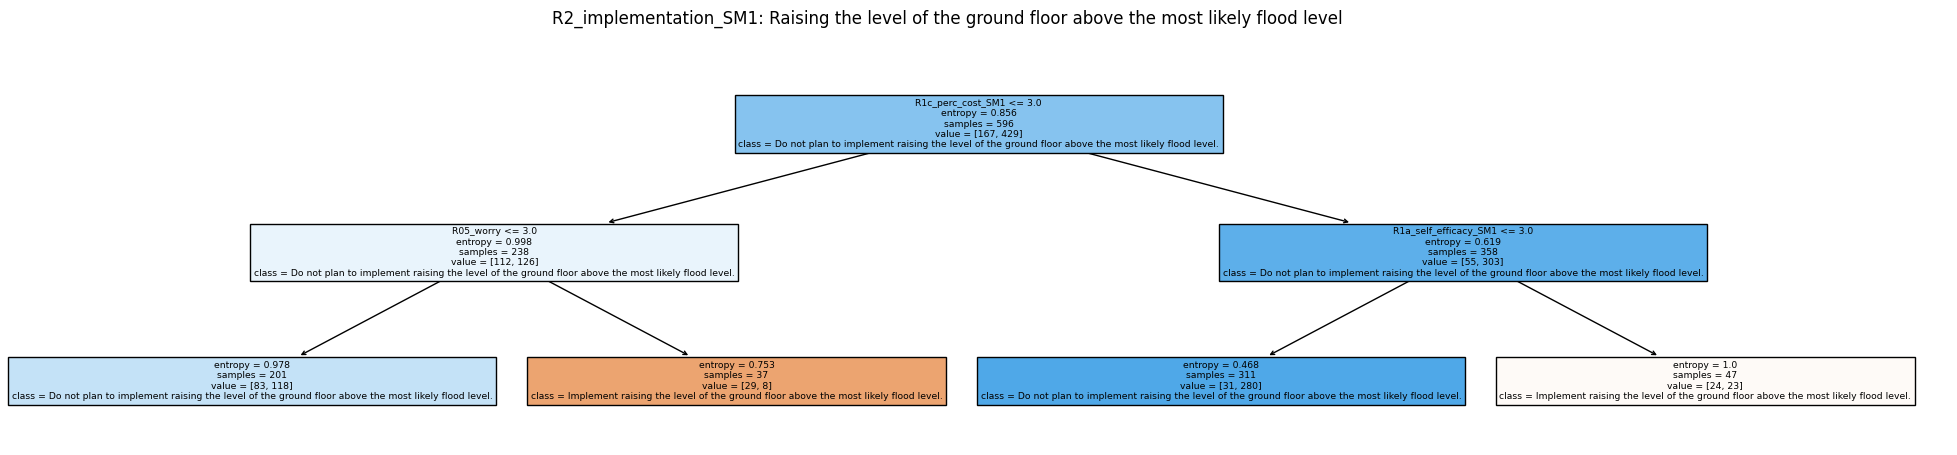

People living in the Netherlands
Processing aim: R2_implementation_SM1: Raising the level of the ground floor above the most likely flood level


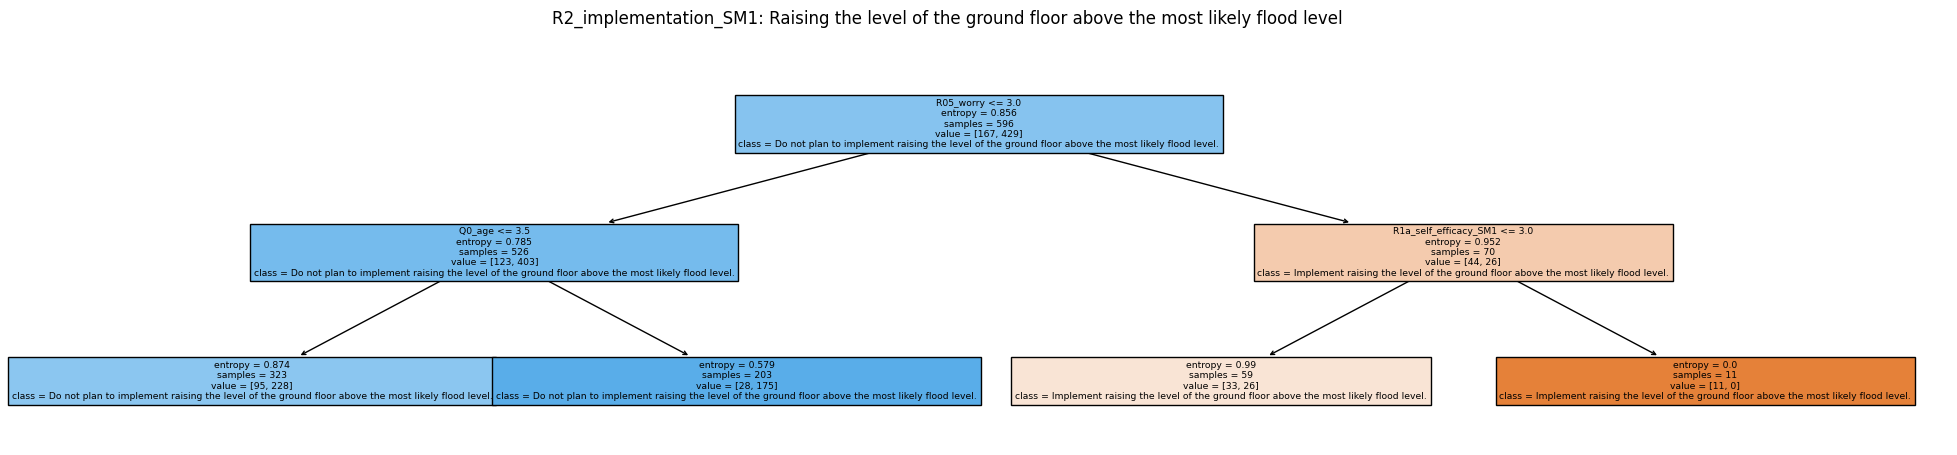

People living in the Netherlands
Processing aim: R2_implementation_SM2: Strengthen the housing foundations to withstand water pressures
R1c_perc_cost_SM2_4.0    if they believe that implementing or paying so...
R1c_perc_cost_SM2_5.0    if they believe that implementing or paying so...
Name: IG_Component, dtype: object


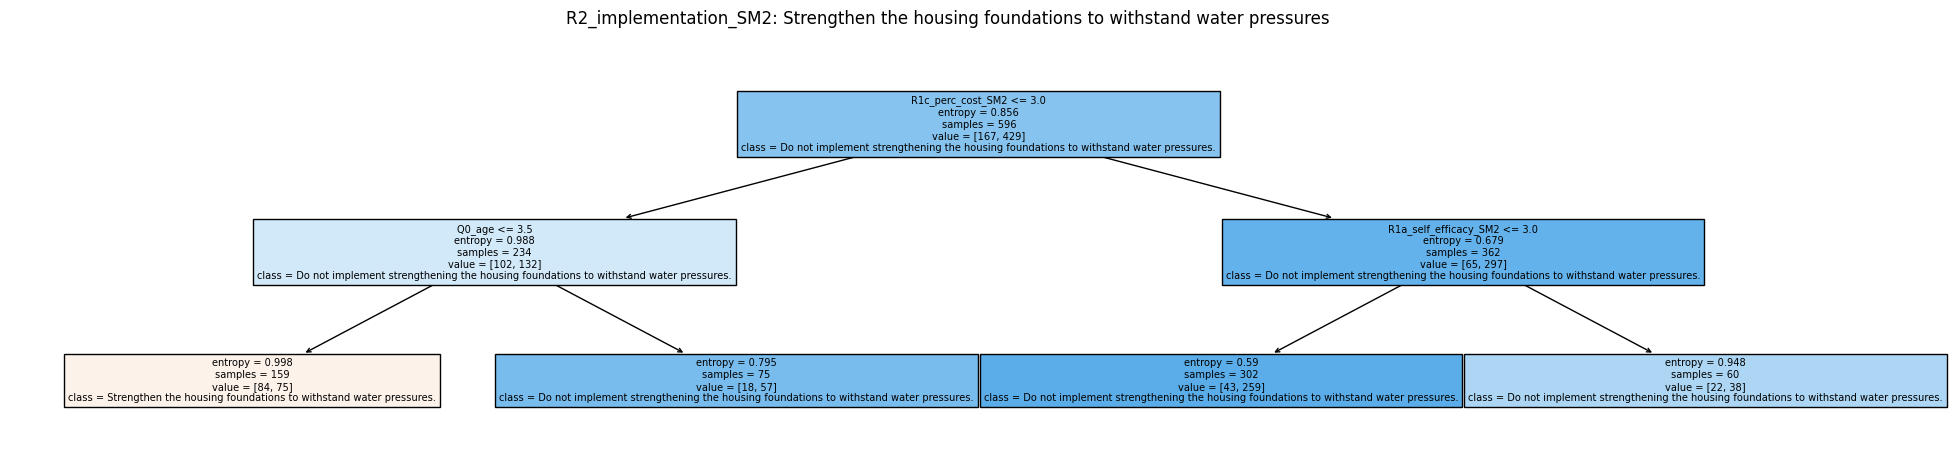

People living in the Netherlands
Processing aim: R2_implementation_SM2: Strengthen the housing foundations to withstand water pressures


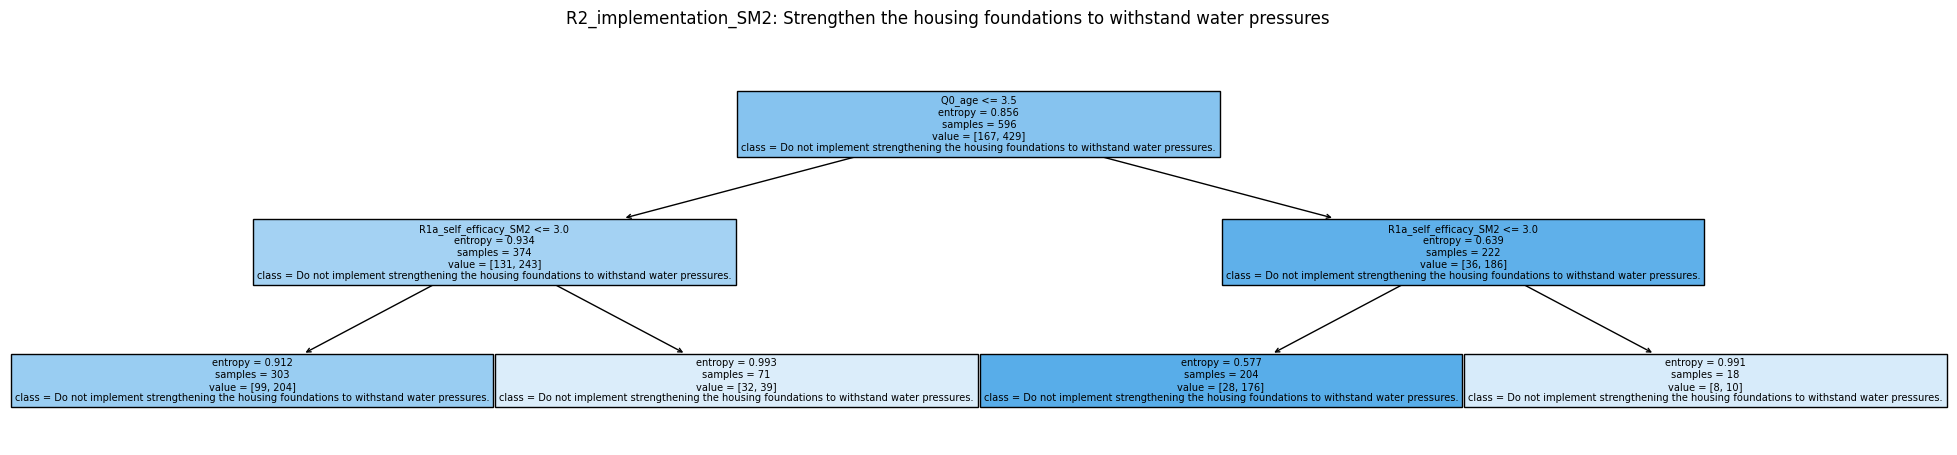

People living in the Netherlands
Processing aim: R2_implementation_SM3: Reconstructing or reinforcing the walls and/or the ground floor with water-resistant materials


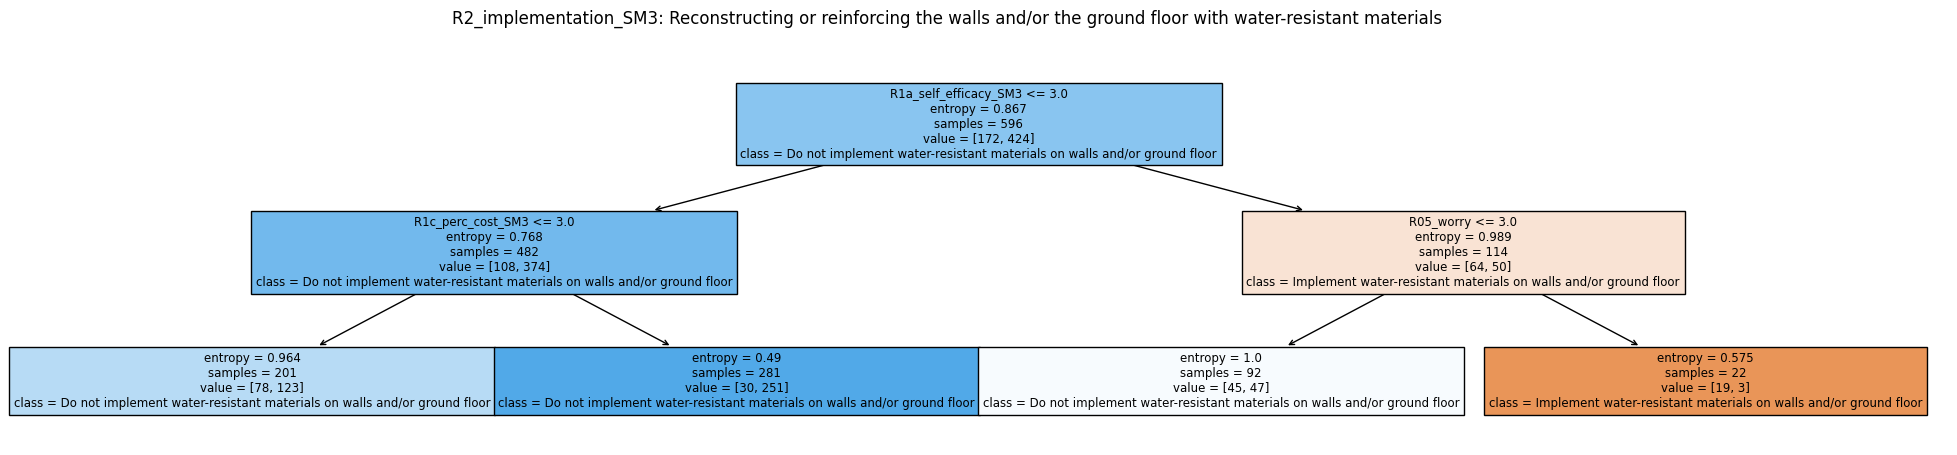

People living in the Netherlands
Processing aim: R2_implementation_SM3: Reconstructing or reinforcing the walls and/or the ground floor with water-resistant materials
R1c_perc_cost_SM3_4.0    if they believe that implementing or paying so...
R1c_perc_cost_SM3_5.0    if they believe that implementing or paying so...
Name: IG_Component, dtype: object


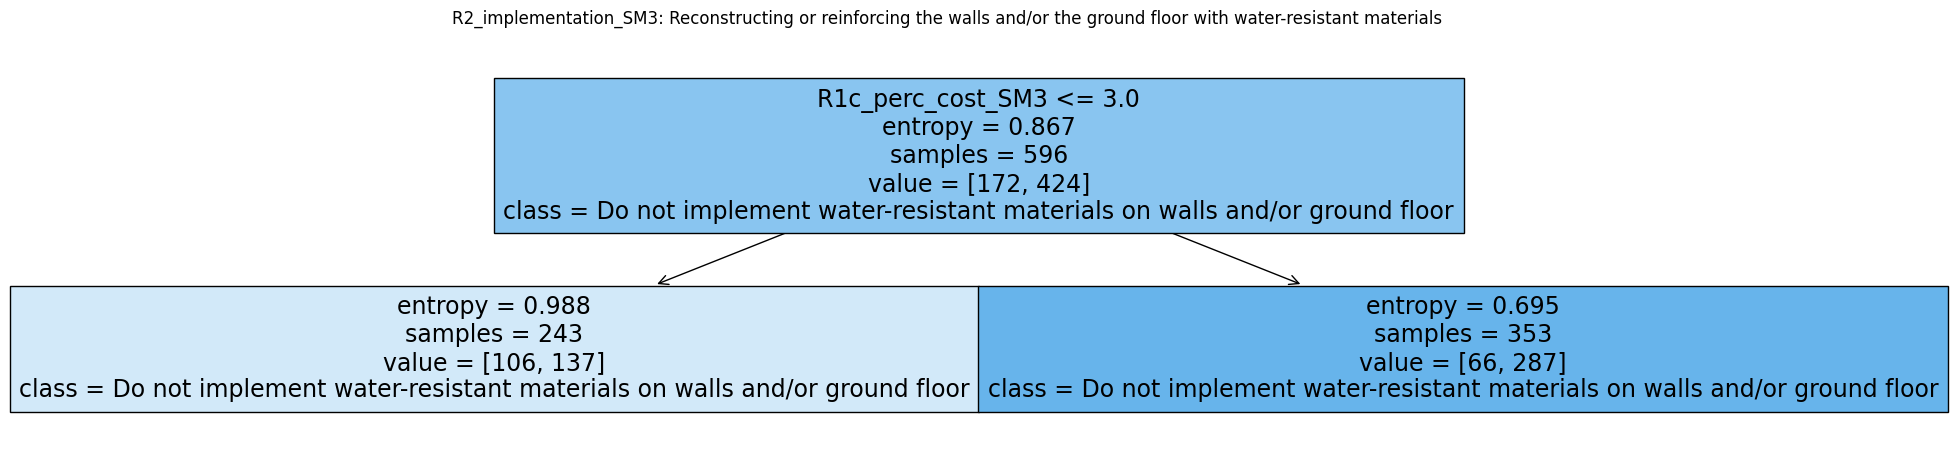

People living in the Netherlands
Processing aim: R2_implementation_NM4: Being an active member in a community group aimed at making the community safer


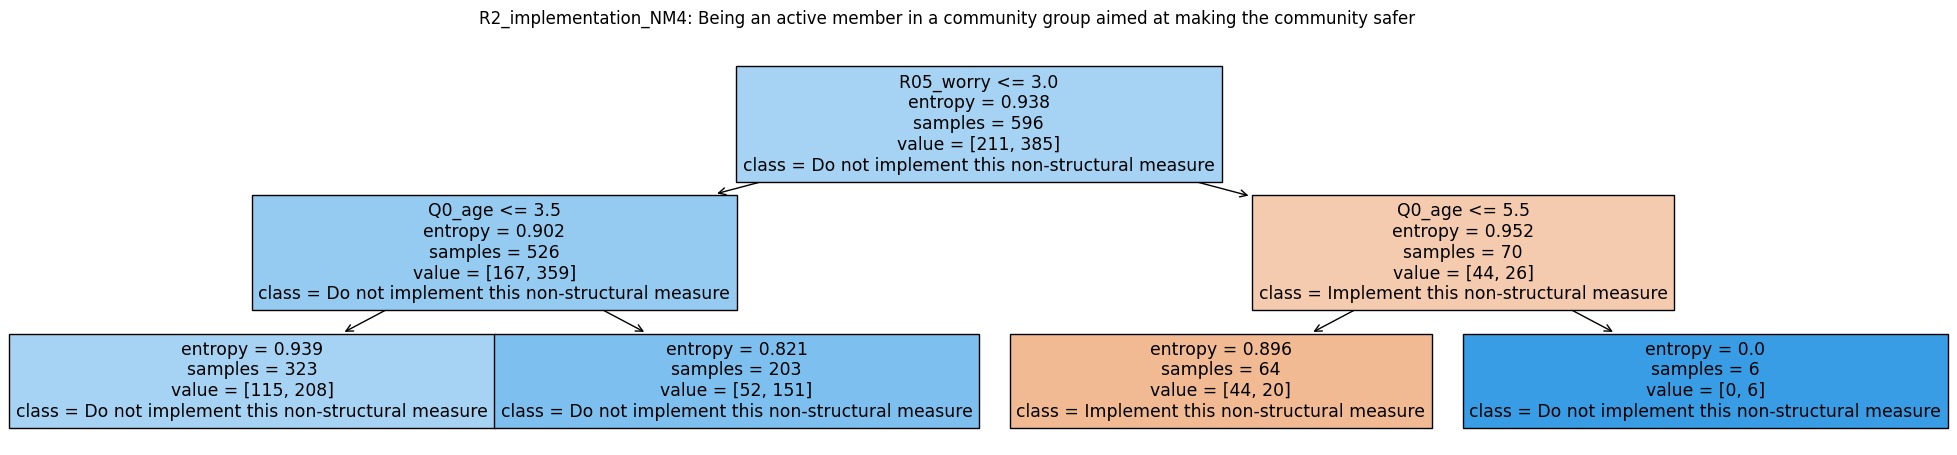

People living in the Netherlands
Processing aim: R2_implementation_NM4: Being an active member in a community group aimed at making the community safer
People living in the Netherlands
Processing aim: R2_implementation_NM2: Purchasing sandbags, or other water barriers


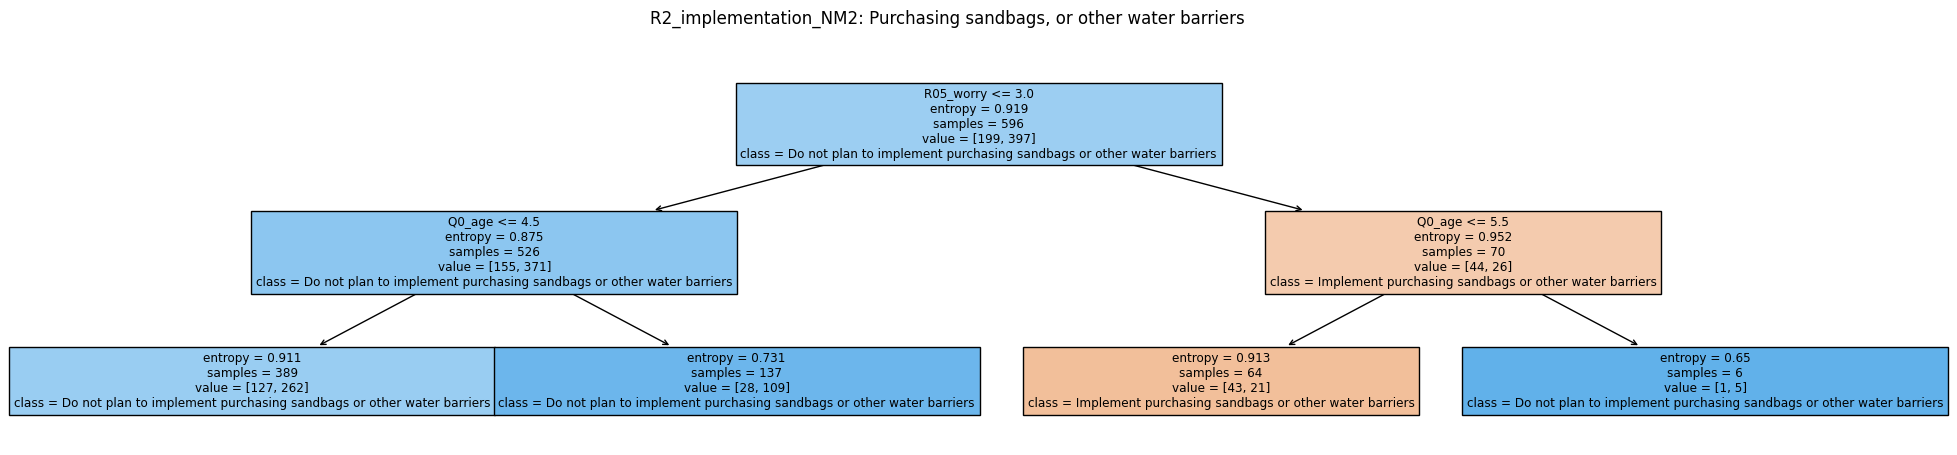

People living in the Netherlands
Processing aim: R2_implementation_NM2: Purchasing sandbags, or other water barriers


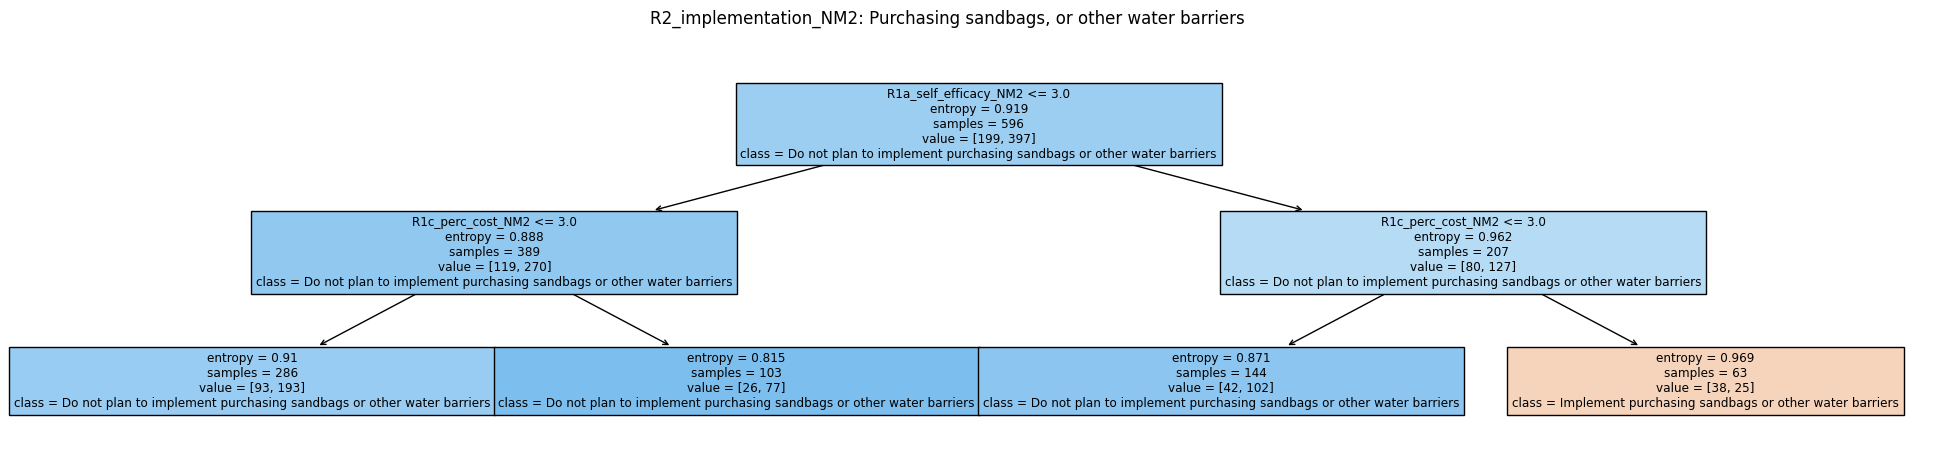

People living in the Netherlands
Processing aim: R2_implementation_NM3: Buying a spare power generator to power your home


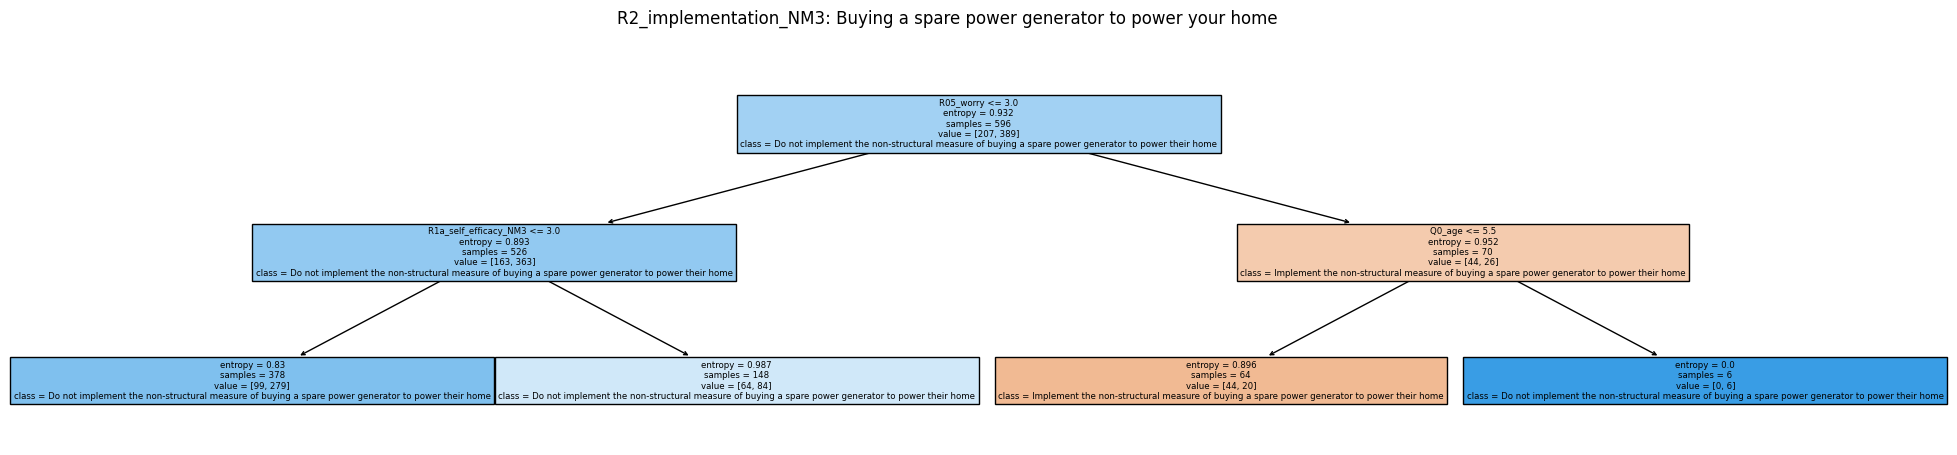

People living in the Netherlands
Processing aim: R2_implementation_NM3: Buying a spare power generator to power your home


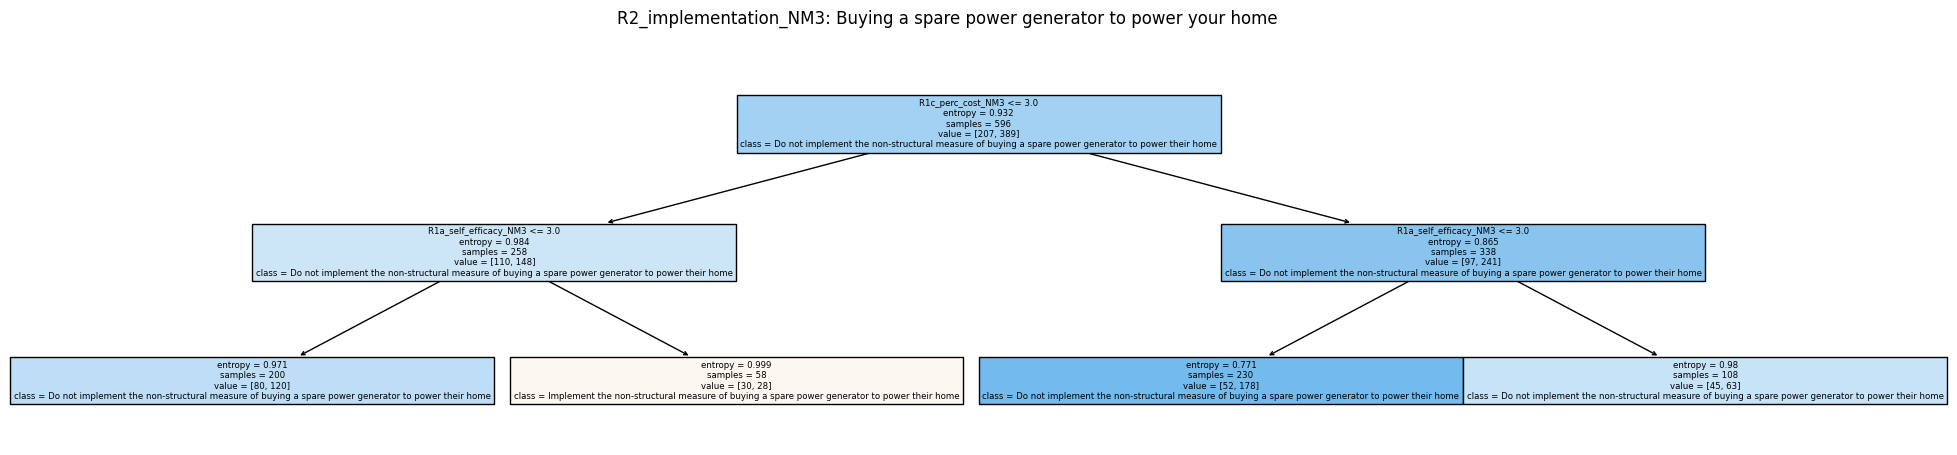

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,358,0.846369,"(None,)",None,,358,0.846369,0.618853
1,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,358,0.846369,R1a_self_efficacy_SM1,Raising the level of the ground floor above th...,if they are unable to undertake the structural...,311,0.900322,0.467975
2,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,526,0.766160,"(None,)",None,,526,0.766160,0.784646
3,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,362,0.820442,"(None,)",None,,362,0.820442,0.679109
4,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,362,0.820442,R1a_self_efficacy_SM2,Strengthen the housing foundations to withstan...,if they are unable to undertake the structural...,302,0.857616,0.590449
5,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",222,0.837838,"(None,)",None,,222,0.837838,0.639457
6,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are unable to undertake the structural...,482,0.775934,"(None,)",None,,482,0.775934,0.767523
7,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are unable to undertake the structural...,482,0.775934,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,281,0.893238,0.490070
8,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,353,0.813031,"(None,)",None,,353,0.813031,0.695087
9,People living in the Netherlands,R2_implementation_NM4,Being an active member in a community group ai...,Do not implement this non-structural measure,596,0.645973,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,526,0.682510,Q0_age,Age,"if they are 45-54, if they are 55-64, if they ...",203,0.743842,0.820893


In [39]:
#You can change these values:
entropy_threshold = 0.85 #How much entropy can the node have (yes aim:no aim) to be considered?
sample_threshold = 0.25 #What proportion of the original sample size to be considered?

for item in range(len(chosen_aims)):
    aim = [chosen_aims[item]]
    conditions = base_conditions + [efficacy_conditions[item]] + [cost_conditions[item]]
    statement_questions =  select_statements(aim, conditions, adjusted_responses, statement_questions, "People living in the Netherlands", entropy_threshold, sample_threshold, 0)

display(statement_questions)

# Save the DataFrame to a CSV file
statement_questions.to_csv("tree_selected_statements.csv", index=False)

AI - IG Statement generator:


In [130]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from io import StringIO

import sys
import json
# Add the parent directory to the path
sys.path.append('..')

# Now you can import the config module
from config import groqkey, OPENAI_Key

In [95]:
# Load the DataFrame from a CSV file
statement_questions = pd.read_csv("tree_selected_statements.csv")
edited_statement_questions = pd.DataFrame(columns=['Attribute', 'Aim', 'Condition1', 'Condition2'])
edited_statement_questions['Attribute'] = statement_questions['Attribute'].copy()  
edited_statement_questions.loc[:, 'Aim'] = statement_questions['Aim_description'] + " Response: " + statement_questions['Aim_resp'] 
edited_statement_questions.loc[:, 'Condition1'] = statement_questions['Condition1_description']  + " Response: " + statement_questions['Condition1_resp']
edited_statement_questions.loc[:, 'Condition2'] = statement_questions['Condition2_description']  + " Response: " + statement_questions['Condition2_resp']

# Convert the DataFrame to JSON text
json_text = edited_statement_questions.to_json()

# Print the JSON text
print(json_text)

{"Attribute":{"0":"People living in the Netherlands","1":"People living in the Netherlands","2":"People living in the Netherlands","3":"People living in the Netherlands","4":"People living in the Netherlands","5":"People living in the Netherlands","6":"People living in the Netherlands","7":"People living in the Netherlands","8":"People living in the Netherlands","9":"People living in the Netherlands","10":"People living in the Netherlands","11":"People living in the Netherlands","12":"People living in the Netherlands","13":"People living in the Netherlands","14":"People living in the Netherlands"},"Aim":{"0":"Raising the level of the ground floor above the most likely flood level, Please indicate if you have already implemented any of these structural measures or if you intend to do so in the future Response:  does not intend to implement","1":"Raising the level of the ground floor above the most likely flood level, Please indicate if you have already implemented any of these structura

In [139]:
csv_text = edited_statement_questions.rename_axis('Index').to_csv()

In [142]:
csv_text

'Index,Attribute,Aim,Condition1,Condition2\r\n0,People living in the Netherlands,"Raising the level of the ground floor above the most likely flood level, Please indicate if you have already implemented any of these structural measures or if you intend to do so in the future Response:  does not intend to implement",,\r\n1,People living in the Netherlands,"Raising the level of the ground floor above the most likely flood level, Please indicate if you have already implemented any of these structural measures or if you intend to do so in the future Response:  does not intend to implement","How worried or not are you about the potential impact of flooding on your home?,  Response: if they are not at all worried about the potential impact of flooding on their home",\r\n2,People living in the Netherlands,"Raising the level of the ground floor above the most likely flood level, Please indicate if you have already implemented any of these structural measures or if you intend to do so in the fu

In [155]:
##Json Approach

statlist = []
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[3], api_key=groqkey)
# models = ["gpt-3.5-turbo-0125", "gpt-4o"]
# llm = ChatOpenAI(temperature=0, model=models[1], api_key=OPENAI_Key)


"""Here is an example: "Attribute": "People", "Aim":"do this specific action", "Condition1": "if this condition is met", "Condition2": "and this condition is met" """

def ExampleCompletionFunction(request):
    system = f"""You are a CSV interpreter that converts survey questions and responses into structured statements depicting group actions influenced by specific conditions.

  The input CSV will have the following columns:
  - 'Attribute': The demographic of the survey responses.
  - 'Aim': The action question the responders were asked and the aggregated response to the aim.
  - 'Condition1': The first related condition question the responders were asked and the aggregated response to the first condition question.
  - 'Condition2': The second related condition question the responders were asked and the aggregated response to the second condition question.

  Your task is to rewrite each row of the provided CSV and generate the following columns for the output CSV:
  - 'Attribute': Retain the value of 'Attribute'.
  - 'Aim': Combine and rewrite 'Aim' as an action starting with a base form/infinitive verb, be as specific as possible.
  - 'Condition1': Combine and rewrite 'Condition1' as a condition that should be met, starting with 'if' and using third-person/they.
  - 'Condition2': Combine and rewrite 'Condition2' as a condition that should be met, starting with 'and if' and using third-person/they.

  If a column value is null, leave that column value blank. Do not remove the entire row and do not replace it with another column value.

  The output should allow combining 'Attribute' + 'Aim' + 'Condition1' + 'Condition2' to form a complete third-person sentence describing the behavior of the demographic.

  Be concise but do not oversimplify or generalize the actions and conditions. Maintain any negative language.
  Use ':' as the separator, include the row numbers and the column names exlcuding index.
  Treat each row separately and produce the same number of rows as provided in the input. The output should contain the same number of rows as the input."
                """
    human = "{text}"
    prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | llm
    response = chain.invoke({"text": request})
    return response.content

IG_Statement = ExampleCompletionFunction(csv_text)
print(IG_Statement)
statlist.append(IG_Statement)

Here is the output CSV:

Index:Attribute:Aim:Condition1:Condition2
0:People living in the Netherlands:do not implement raising the level of the ground floor above the most likely flood level:,: 
1:People living in the Netherlands:do not implement raising the level of the ground floor above the most likely flood level:if they are not at all worried about the potential impact of flooding on their home:,
2:People living in the Netherlands:do not implement raising the level of the ground floor above the most likely flood level:if they are not at all worried about the potential impact of flooding on their home:and if they are unable to undertake the structural measure themselves or pay a professional to do so
3:People living in the Netherlands:do not implement raising the level of the ground floor above the most likely flood level:if they believe that implementing or paying someone to implement this structural measure would be very expensive:, 
4:People living in the Netherlands:do not impl

In [157]:
# Extract the CSV part from the text
csv_data = IG_Statement.split("\n", 2)[2]

# Convert the CSV data to a pandas DataFrame
IG_component_df = pd.read_csv(StringIO(csv_data),sep=":",index_col=0)

# Display the DataFrame
IG_component_df

,Attribute,Aim,Condition1,Condition2
Index,,,,
0,People living in the Netherlands,do not implement raising the level of the grou...,",",
1,People living in the Netherlands,do not implement raising the level of the grou...,if they are not at all worried about the poten...,","
2,People living in the Netherlands,do not implement raising the level of the grou...,if they are not at all worried about the poten...,and if they are unable to undertake the struct...
3,People living in the Netherlands,do not implement raising the level of the grou...,if they believe that implementing or paying so...,","
4,People living in the Netherlands,do not implement raising the level of the grou...,if they believe that implementing or paying so...,and if they are unable to undertake the struct...
5,People living in the Netherlands,do not implement raising the level of the grou...,"if they are 45-54, if they are 55-64, or if th...",","
6,People living in the Netherlands,do not implement strengthening the housing fou...,"if they are 45-54, if they are 55-64, or if th...",","
7,People living in the Netherlands,do not implement strengthening the housing fou...,"if they are 45-54, if they are 55-64, or if th...",and if they believe that implementing or payin...
8,People living in the Netherlands,do not implement strengthening the housing fou...,if they believe that implementing or paying so...,","


In [119]:
##Json Approach

statlist = []
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[3], api_key=groqkey)
# models = ["gpt-3.5-turbo-0125", "gpt-4o"]
# llm = ChatOpenAI(temperature=0, model=models[1], api_key=OPENAI_Key)


"""Here is an example: "Attribute": "People", "Aim":"do this specific action", "Condition1": "if this condition is met", "Condition2": "and this condition is met" """

def ExampleCompletionFunction(request):
    system = f"""You are a JSON interpreter that converts survey questions and responses into structured statements depicting group actions influenced by specific conditions.

The input JSON will have the following variables:
  - 'Attribute': The demographic of the survey responses.
  - 'Aim': The action question the responders were asked and the aggregated response to the aim.
  - 'Condition1': The first related condition question the responders were asked and the aggregated response to the first condition question.
  - 'Condition2': The second related condition question the responders were asked and the aggregated response to the second condition question.

  Your task is to rewrite the provided JSON and generate the following keys for the output JSON:
  - 'Attribute': Retain the value of 'Attribute'.
  - 'Aim': Combine and rewrite 'Aim' as an action starting with a base form/infinitive verb, clearly stating what they are implementing.
  - 'Condition1': Combine and rewrite 'Condition1' as a condition that should be met, starting with 'if' and using third-person/they.
  - 'Condition2': Combine and rewrite 'Condition2' as a condition that should be met, starting with 'and if' and using third-person/they.

  If a key value is null, leave that key value blank. Do not remove the entire object and do not replace it with another key value.

  The output should allow combining 'Attribute' + 'Aim' + 'Condition1' + 'Condition2' to form a complete third-person sentence describing the behavior of the demographic.

  Be concise but do not oversimplify or generalize the actions and conditions. Maintain any negative language.

  Treat each object separately and produce the same number of objects as provided in the input. The output should contain {len(edited_statement_questions)} items.
                """
    human = "{text}"
    prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | llm
    response = chain.invoke({"text": request})
    return response.content

IG_Statement = ExampleCompletionFunction(json_text)
print(IG_Statement)
statlist.append(IG_Statement)

Here is the rewritten JSON output:

```
[
  {
    "Attribute": "People living in the Netherlands",
    "Aim": "are not implementing raising the level of the ground floor above the most likely flood level",
    "Condition1": "if they are not at all worried about the potential impact of flooding on their home",
    "Condition2": ""
  },
  {
    "Attribute": "People living in the Netherlands",
    "Aim": "are not implementing raising the level of the ground floor above the most likely flood level",
    "Condition1": "if they are not at all worried about the potential impact of flooding on their home",
    "Condition2": ""
  },
  {
    "Attribute": "People living in the Netherlands",
    "Aim": "are not implementing raising the level of the ground floor above the most likely flood level",
    "Condition1": "if they believe that implementing or paying someone to implement this structural measure would be very expensive",
    "Condition2": "if they are unable to undertake the structural meas

In [120]:
df = pd.DataFrame(columns=["Attribute","Aim","Condition1", "Condition2"])
try:
    # Parse the JSON string into a Python dictionary
    data_dict = json.loads(IG_Statement)
except:
    # Parse the JSON string into a Python dictionary
    data_dict = json.loads('['+IG_Statement.split('[')[1].split(']')[0]+']')        

# Convert the dictionary to a DataFrame
# Since we have only one record, we wrap it in a list to make a single-row DataFrame
IG_component_df = pd.DataFrame(data_dict)

display(IG_component_df)

,Attribute,Aim,Condition1,Condition2
0,People living in the Netherlands,are not implementing raising the level of the ...,if they are not at all worried about the poten...,
1,People living in the Netherlands,are not implementing raising the level of the ...,if they are not at all worried about the poten...,
2,People living in the Netherlands,are not implementing raising the level of the ...,if they believe that implementing or paying so...,if they are unable to undertake the structural...
3,People living in the Netherlands,are not implementing raising the level of the ...,if they believe that implementing or paying so...,if they are unable to undertake the structural...
4,People living in the Netherlands,are not implementing raising the level of the ...,"if they are 45-54, if they are 55-64, if they ...",
5,People living in the Netherlands,are not implementing strengthening the housing...,"if they are 45-54, if they are 55-64, if they ...",
6,People living in the Netherlands,are not implementing strengthening the housing...,"if they are 45-54, if they are 55-64, if they ...",
7,People living in the Netherlands,are not implementing strengthening the housing...,if they believe that implementing or paying so...,
8,People living in the Netherlands,are not implementing reconstructing or reinfor...,"if they are 45-54, if they are 55-64, if they ...",
9,People living in the Netherlands,are not implementing reconstructing or reinfor...,"if they are 45-54, if they are 55-64, if they ...",


In [108]:
statement_questions

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,"(None,)",NaN,NaN,1125,0.768000,"(None,)",NaN,NaN,1125,0.768000,0.781481
1,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,989,0.813953,"(None,)",NaN,NaN,989,0.813953,0.693127
2,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,989,0.813953,R1a_self_efficacy_SM1,Raising the level of the ground floor above th...,if they are unable to undertake the structural...,892,0.831839,0.653482
3,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,733,0.885402,"(None,)",NaN,NaN,733,0.885402,0.513630
4,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,733,0.885402,R1a_self_efficacy_SM1,Raising the level of the ground floor above th...,if they are unable to undertake the structural...,657,0.922374,0.393757
5,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,does not intend to implement,1125,0.768000,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",485,0.905155,"(None,)",NaN,NaN,485,0.905155,0.452439
6,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,does not intend to implement,1159,0.759275,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",491,0.906314,"(None,)",NaN,NaN,491,0.906314,0.448656
7,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,does not intend to implement,1159,0.759275,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",491,0.906314,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,350,0.940000,0.327445
8,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,does not intend to implement,1159,0.759275,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,758,0.849604,"(None,)",NaN,NaN,758,0.849604,0.610830
9,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,does not intend to implement,1154,0.744367,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",489,0.901840,"(None,)",NaN,NaN,489,0.901840,0.463134


In [158]:
# Make final file
statements_stats = pd.concat([
                                 IG_component_df['Attribute'], 
                                 IG_component_df['Aim'], 
                                 statement_questions[['Total_count', 'Aim_%_True']],
                                 IG_component_df['Condition1'], 
                                 statement_questions[['Condition1_count', 'Condition1_Aim_%',]],
                                 IG_component_df['Condition2'],
                                 statement_questions[['Condition2_count', 'Condition2_Aim_%']], 
                                 ], axis=1)


# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('SelectedandConvertedStatements.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
statements_stats.to_excel(writer, sheet_name='IGStatementStats', index=False)
statement_questions.to_excel(writer, sheet_name='QuestionResults', index=False)
IG_component_df.to_excel(writer, sheet_name='JustIGstatements', index=False)

# Close the Pandas Excel writer and output the Excel file
writer.close()

statements_stats

,Attribute,Aim,Total_count,Aim_%_True,Condition1,Condition1_count,Condition1_Aim_%,Condition2,Condition2_count,Condition2_Aim_%
0,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,",",1125,0.768000,,1125,0.768000
1,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,if they are not at all worried about the poten...,989,0.813953,",",989,0.813953
2,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,if they are not at all worried about the poten...,989,0.813953,and if they are unable to undertake the struct...,892,0.831839
3,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,if they believe that implementing or paying so...,733,0.885402,",",733,0.885402
4,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,if they believe that implementing or paying so...,733,0.885402,and if they are unable to undertake the struct...,657,0.922374
5,People living in the Netherlands,do not implement raising the level of the grou...,1125,0.768000,"if they are 45-54, if they are 55-64, or if th...",485,0.905155,",",485,0.905155
6,People living in the Netherlands,do not implement strengthening the housing fou...,1159,0.759275,"if they are 45-54, if they are 55-64, or if th...",491,0.906314,",",491,0.906314
7,People living in the Netherlands,do not implement strengthening the housing fou...,1159,0.759275,"if they are 45-54, if they are 55-64, or if th...",491,0.906314,and if they believe that implementing or payin...,350,0.940000
8,People living in the Netherlands,do not implement strengthening the housing fou...,1159,0.759275,if they believe that implementing or paying so...,758,0.849604,",",758,0.849604
9,People living in the Netherlands,do not implement reconstructing or reinforcing...,1154,0.744367,"if they are 45-54, if they are 55-64, or if th...",489,0.901840,",",489,0.901840


In [40]:
statement_questions

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,358,0.846369,"(None,)",None,,358,0.846369,0.618853
1,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R1c_perc_cost_SM1,Raising the level of the ground floor above th...,if they believe that implementing or paying so...,358,0.846369,R1a_self_efficacy_SM1,Raising the level of the ground floor above th...,if they are unable to undertake the structural...,311,0.900322,0.467975
2,People living in the Netherlands,R2_implementation_SM1,Raising the level of the ground floor above th...,Do not plan to implement raising the level of ...,596,0.719799,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,526,0.766160,"(None,)",None,,526,0.766160,0.784646
3,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,362,0.820442,"(None,)",None,,362,0.820442,0.679109
4,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,R1c_perc_cost_SM2,Strengthen the housing foundations to withstan...,if they believe that implementing or paying so...,362,0.820442,R1a_self_efficacy_SM2,Strengthen the housing foundations to withstan...,if they are unable to undertake the structural...,302,0.857616,0.590449
5,People living in the Netherlands,R2_implementation_SM2,Strengthen the housing foundations to withstan...,Do not implement strengthening the housing fou...,596,0.719799,Q0_age,"Age,","if they are 45-54, if they are 55-64, if they ...",222,0.837838,"(None,)",None,,222,0.837838,0.639457
6,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are unable to undertake the structural...,482,0.775934,"(None,)",None,,482,0.775934,0.767523
7,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are unable to undertake the structural...,482,0.775934,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,281,0.893238,0.490070
8,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,Do not implement water-resistant materials on ...,596,0.711409,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,353,0.813031,"(None,)",None,,353,0.813031,0.695087
9,People living in the Netherlands,R2_implementation_NM4,Being an active member in a community group ai...,Do not implement this non-structural measure,596,0.645973,R05_worry,How worried or not are you about the potential...,if they are not at all worried about the poten...,526,0.682510,Q0_age,Age,"if they are 45-54, if they are 55-64, if they ...",203,0.743842,0.820893


In [ ]:
# Make final file
statements_stats = pd.concat([
                                 statement_questions['Attribute'], 
                                 statement_questions['Aim_resp'], 
                                 statement_questions[['Total_count', 'Aim_%_True']],
                                 statement_questions['Condition1_resp'], 
                                 statement_questions[['Condition1_count', 'Condition1_Aim_%']],
                                 statement_questions['Condition2_resp'],
                                 statement_questions[['Condition2_count', 'Condition2_Aim_%']], 
                                 ], axis=1)
statements_stats.columns = ['Attribute', "Aim", 'Total_count', 'Aim_%_True', 'Condition1', 'Condition1_count', 'Condition1_Aim_%', 'Condition2','Condition2_count', 'Condition2_Aim_%']
# Replace empty strings with 'none'
statements_stats.replace('', 'none', inplace=True)

In [10]:
statements_stats[statements_stats.index <= 12]

,Attribute,Aim,Total_count,Aim_%_True,Condition1,Condition1_count,Condition1_Aim_%,Condition2,Condition2_count,Condition2_Aim_%
0,People living in the Netherlands,Do not plan to implement raising the level of ...,596,0.719799,if they believe that implementing or paying so...,358,0.846369,none,358,0.846369
1,People living in the Netherlands,Do not plan to implement raising the level of ...,596,0.719799,if they believe that implementing or paying so...,358,0.846369,if they are unable to undertake the structural...,311,0.900322
2,People living in the Netherlands,Do not plan to implement raising the level of ...,596,0.719799,if they are not at all worried about the poten...,526,0.76616,none,526,0.76616
3,People living in the Netherlands,Do not implement strengthening the housing fou...,596,0.719799,if they believe that implementing or paying so...,362,0.820442,none,362,0.820442
4,People living in the Netherlands,Do not implement strengthening the housing fou...,596,0.719799,if they believe that implementing or paying so...,362,0.820442,if they are unable to undertake the structural...,302,0.857616
5,People living in the Netherlands,Do not implement strengthening the housing fou...,596,0.719799,"if they are 45-54, if they are 55-64, if they ...",222,0.837838,none,222,0.837838
6,People living in the Netherlands,Do not implement water-resistant materials on ...,596,0.711409,if they are unable to undertake the structural...,482,0.775934,none,482,0.775934
7,People living in the Netherlands,Do not implement water-resistant materials on ...,596,0.711409,if they are unable to undertake the structural...,482,0.775934,if they believe that implementing or paying so...,281,0.893238
8,People living in the Netherlands,Do not implement water-resistant materials on ...,596,0.711409,if they believe that implementing or paying so...,353,0.813031,none,353,0.813031
9,People living in the Netherlands,Do not implement this non-structural measure,596,0.645973,if they are not at all worried about the poten...,526,0.68251,"if they are 45-54, if they are 55-64, if they ...",203,0.743842


In [6]:
import pandas as pd
import matplotlib.pyplot as plt


statements_stats = pd.read_excel('SelectedandConvertedStatements.xlsx', sheet_name='IGStatementStats')
statements_stats = statements_stats[statements_stats.index <= 11]



In [55]:
# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('SelectedandConvertedStatements.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
statements_stats.to_excel(writer, sheet_name='IGStatementStats', index=False)
# Close the Pandas Excel writer and output the Excel file
writer.close()


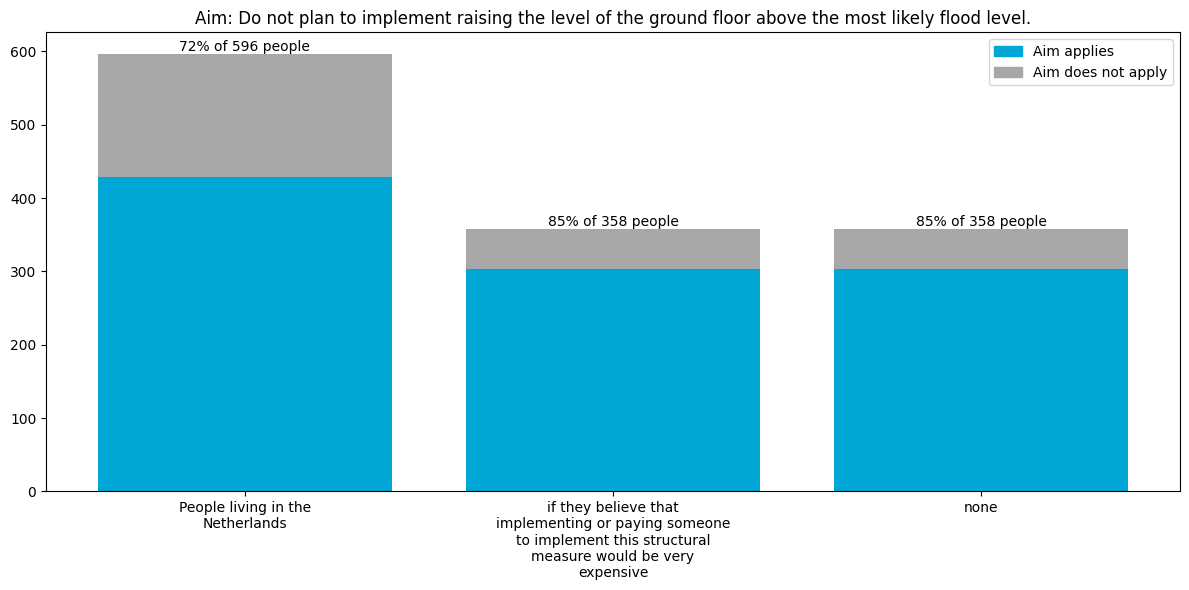

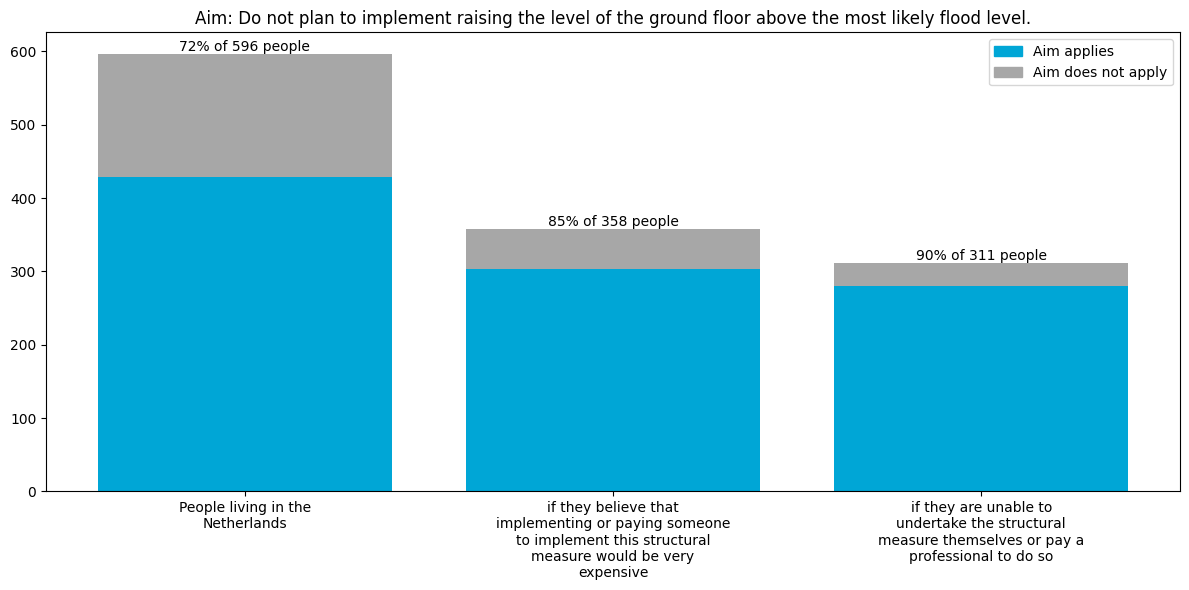

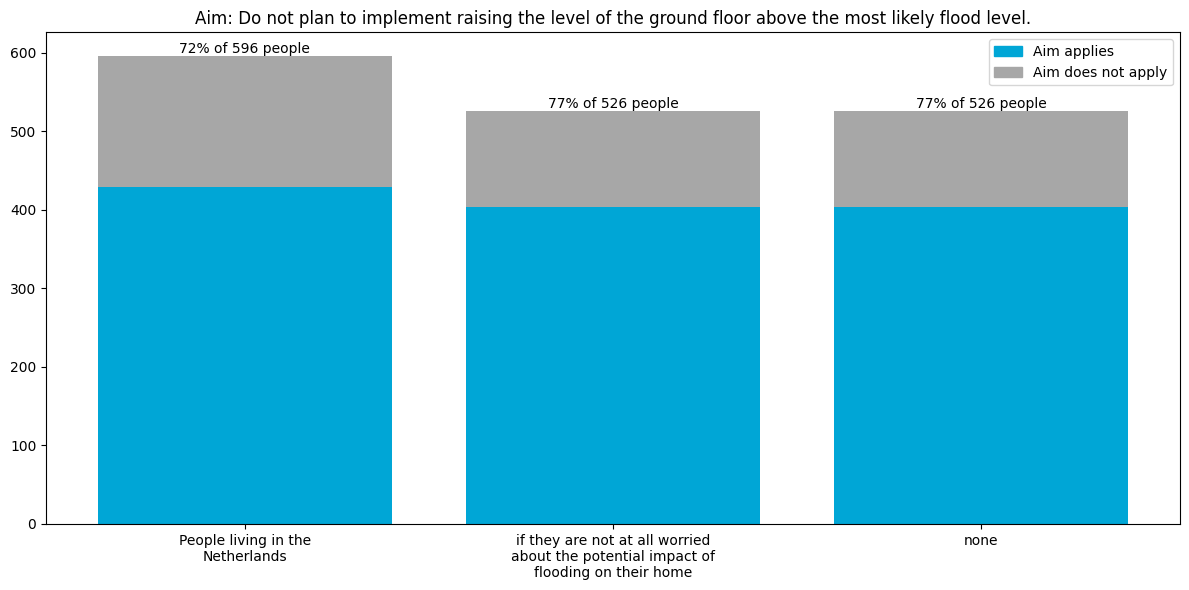

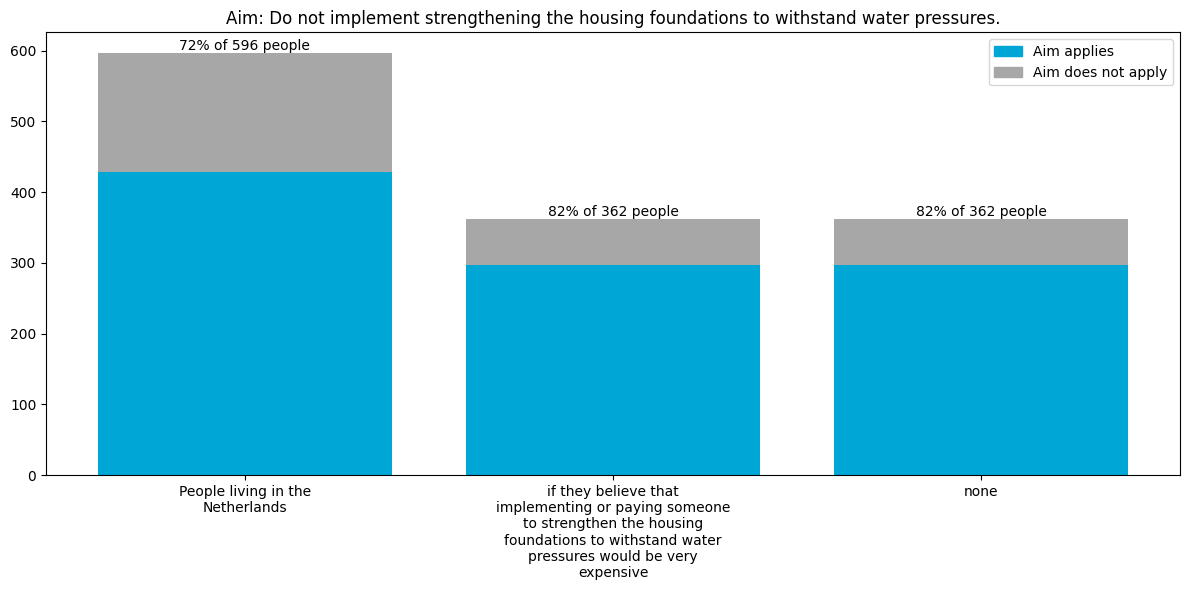

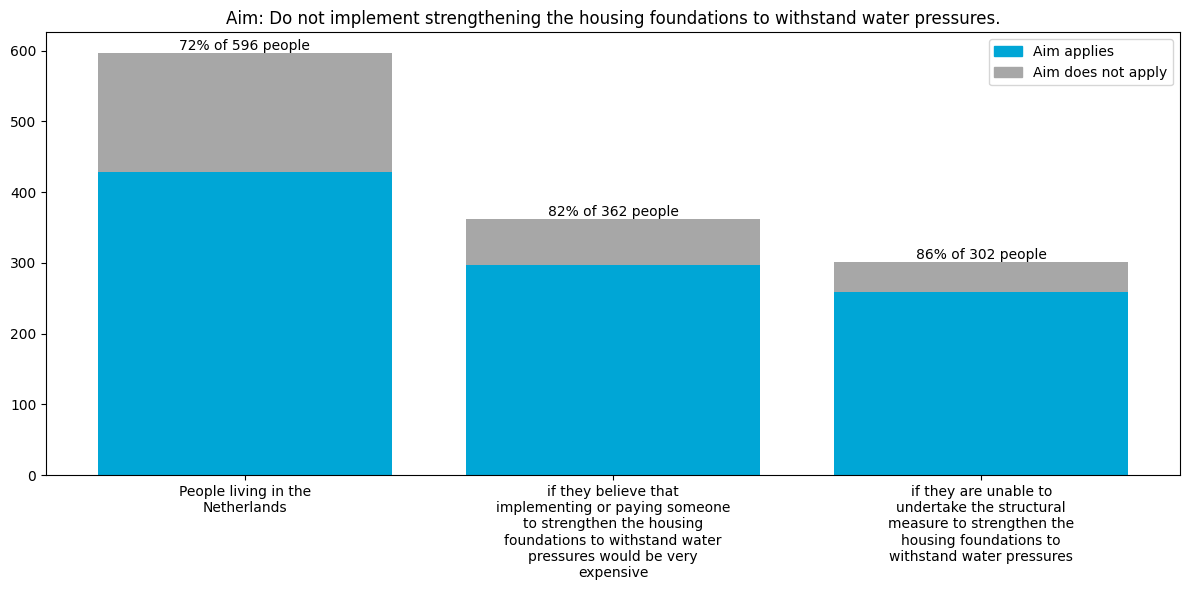

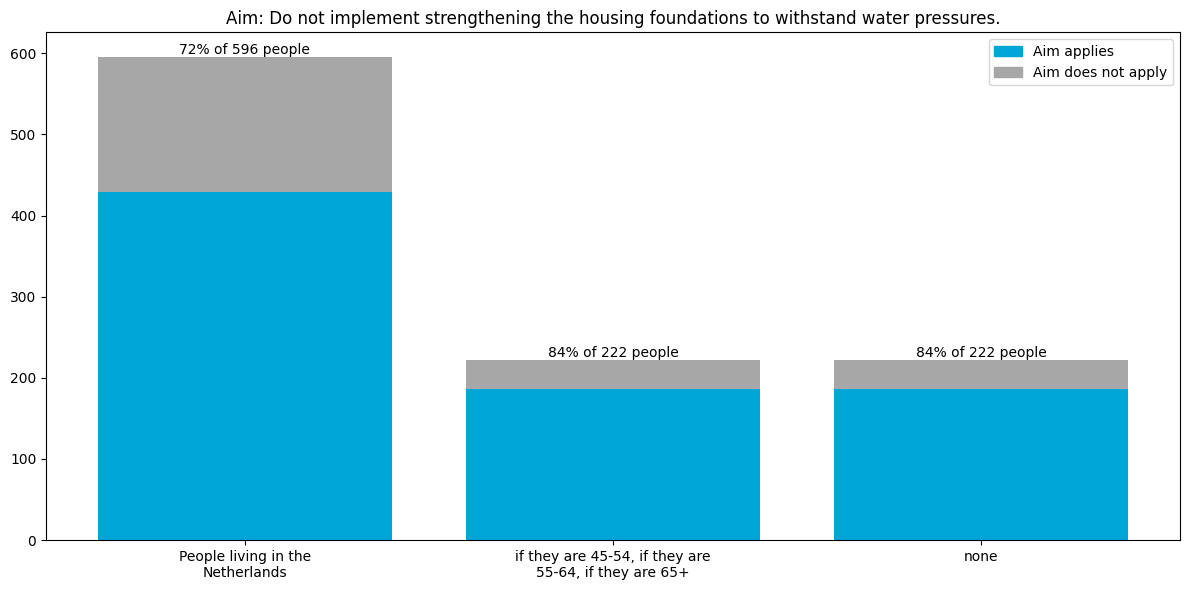

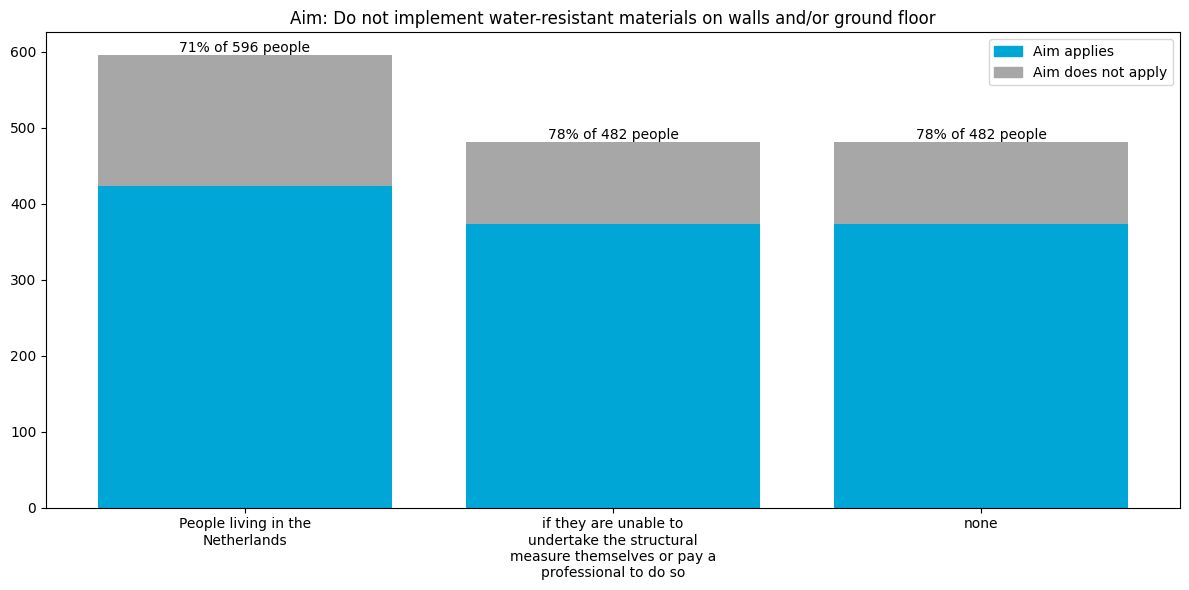

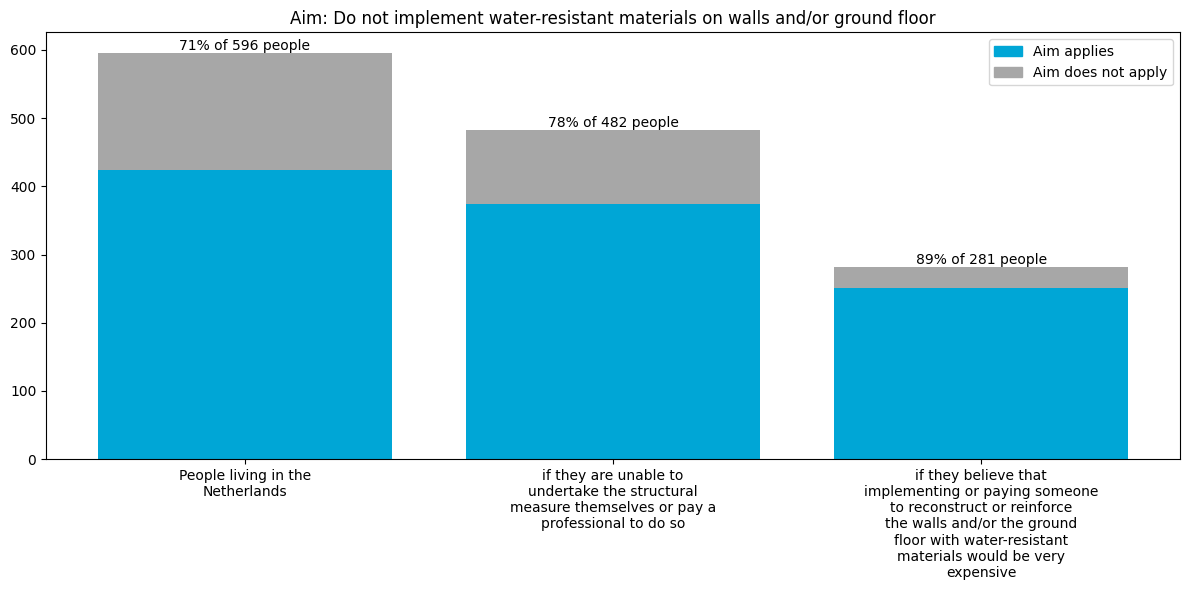

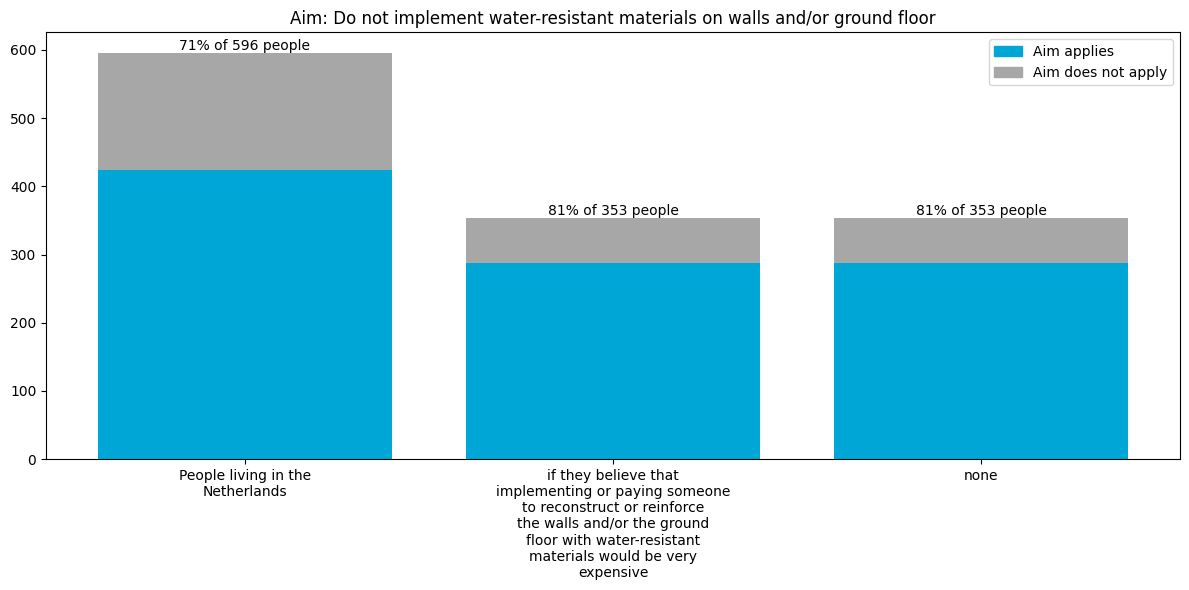

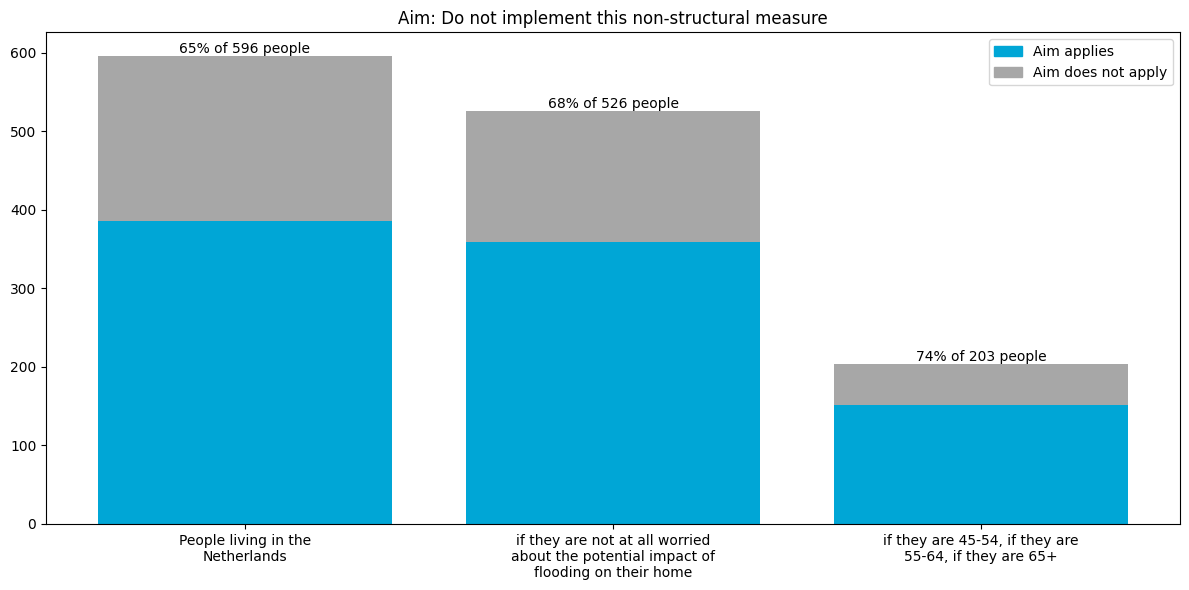

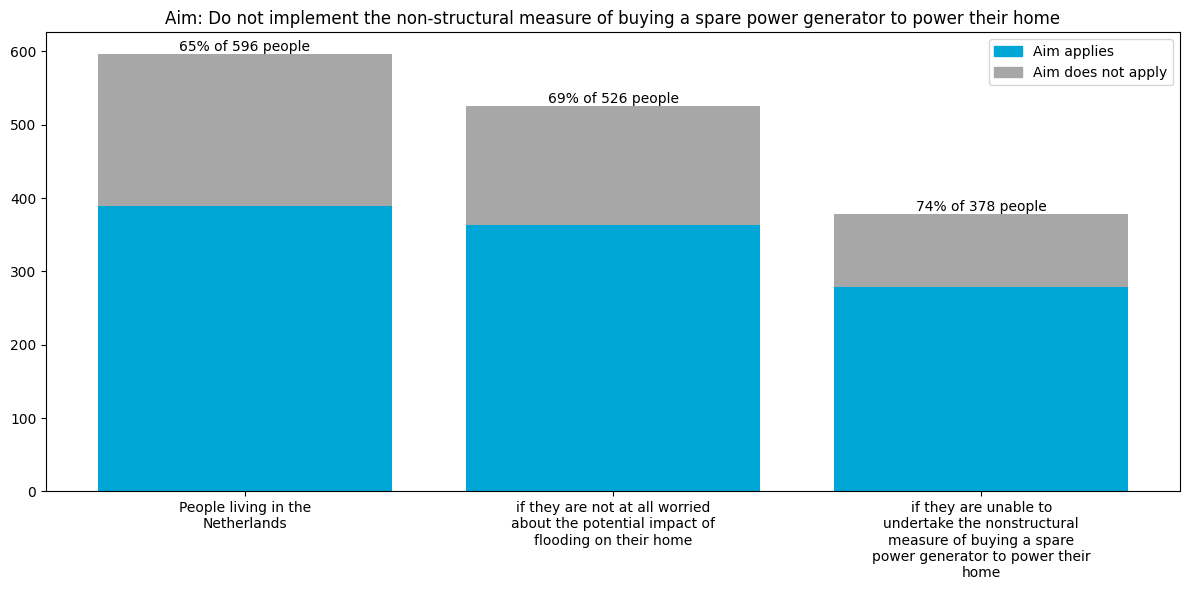

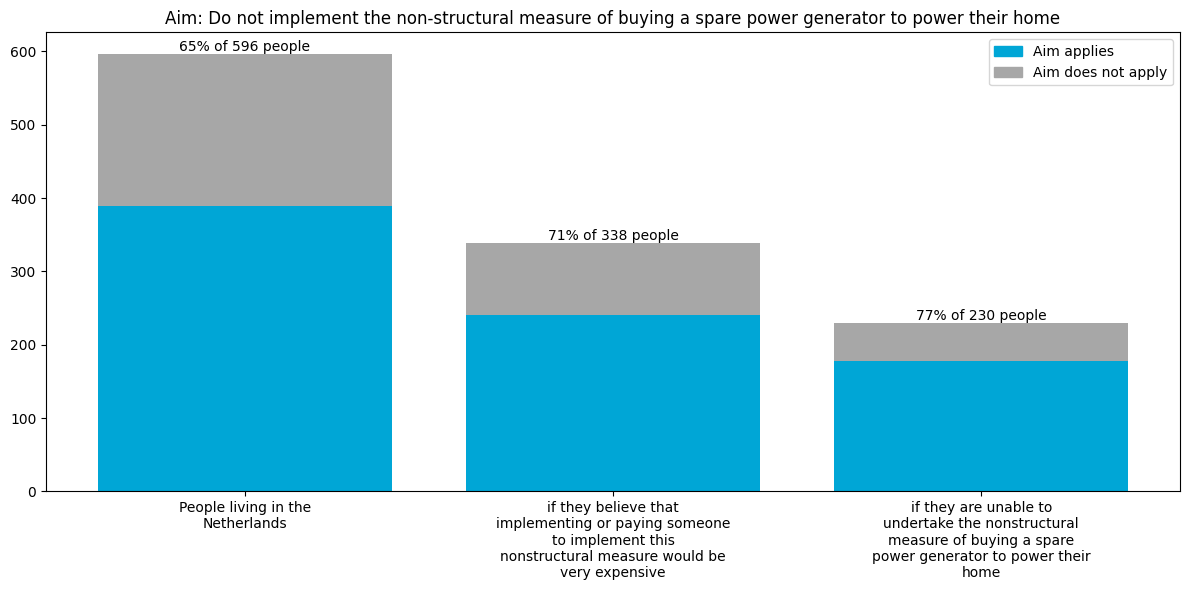

In [7]:
import textwrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

rows = len(statements_stats)

for i, row in statements_stats.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Adding legend
    blue_patch = mpatches.Patch(color='#00a6d6', label='Aim applies')
    grey_patch = mpatches.Patch(color='#a7a7a7', label='Aim does not apply')

    # Bar1: Total_count
    bar1 = ax.bar(row['Attribute'], row['Total_count'], color='#a7a7a7')
    ax.bar(row['Attribute'], row['Total_count'] * row['Aim_%_True'], color='#00a6d6')
    ax.text(row['Attribute'], row['Total_count'], f"{row['Aim_%_True']*100:.0f}% of {row['Total_count']} people", 
            color='black', ha='center', va='bottom')

    # Bar2: Condition1_count
    bar2 = ax.bar(row['Condition1'], row['Condition1_count'], color='#a7a7a7')
    ax.bar(row['Condition1'], row['Condition1_count'] * row['Condition1_Aim_%'], color='#00a6d6')
    ax.text(row['Condition1'], row['Condition1_count'], f"{row['Condition1_Aim_%']*100:.0f}% of {row['Condition1_count']} people", 
            color='black', ha='center', va='bottom')

    # Bar3: Condition2_count
    bar3 = ax.bar(row['Condition2'], row['Condition2_count'], color='#a7a7a7')
    ax.bar(row['Condition2'], row['Condition2_count'] * row['Condition2_Aim_%'], color='#00a6d6')
    ax.text(row['Condition2'], row['Condition2_count'], f"{row['Condition2_Aim_%']*100:.0f}% of {row['Condition2_count']} people", 
            color='black', ha='center', va='bottom')

    # Title of each plot
    ax.set_title("Aim: "+row['Aim'])

    # Set ticks and labels
    ax.set_xticks([0, 1, 2])
    wrapped_labels = [textwrap.fill(label, 30) for label in [row['Attribute'], row['Condition1'], row['Condition2']]]
    ax.set_xticklabels(wrapped_labels, rotation=0)

    ax.legend(handles=[blue_patch, grey_patch], loc='upper right')

    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
import plotly.express as px

# Create a parallel set graph for each aim
for i, row in statements_stats.iterrows():
    data = {
        #first bar
        row['Attribute']: ["does aim", "does not aim"],
        #connects to second bar
        row['Condition1']: ["does aim", "does not aim"],
        #connects to third bar
        row['Condition2']: ["does aim", "does not aim"],
        'Count': [
            row['Total_count'], row['Total_count'] * row['Aim_%_True'],
            #I want to include these that they match condition1 and condition2 bar sizes/values but this gives me array mismatch, how to make this work?
            #second bar counts
            # row['Condition1_count'], row['Condition1_count'] * row['Condition1_Aim_%'],
            #third bar counts
            # row['Condition2_count'], row['Condition2_count'] * row['Condition2_Aim_%']
        ]
    }

    df = pd.DataFrame(data)
    
    fig = px.parallel_categories(
        df,
        dimensions=[row['Attribute'], row['Condition1'], row['Condition2']],
        color='Count',
        # labels={'Attribute': 'Attribute/Condition', 'Condition': 'Total/Aim', 'Count': 'Count'},
        color_continuous_scale=px.colors.sequential.Inferno
    )
    
    fig.update_layout(
        title=f"Aim: {row['Aim']}",
        legend_title_text='Count'
    )

    fig.show()


In [9]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Create a parallel set graph for each aim
for i, row in statements_stats.iterrows():
    print(row)
    aimtrue = row['Aim']
    aimfalse = "not " + row['Aim']
    
    fig = go.Figure()

    # Adding paths
    fig.add_trace(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label = [row["Attribute"], "Do the Aim", "Don't do the Aim", 
                     row['Condition1'], "notcondition1",
                     "do the Aim "+row['Condition1'], "yescondition1butAimfalse", 
                     row['Condition2'], "notcondition2",
                     row['Condition2'] + " do the Aim", "yescondition2butAimfalse", 
                     ]
        ),
        link=dict(
            source=[0, 0, 1, 1, 3, 3, 5, 5, 7, 7],
            target=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            value=[row['Total_count'] * row['Aim_%_True'], row['Total_count'] * (1 - row['Aim_%_True']), 
                   row['Condition1_count'], row['Total_count'] * row['Aim_%_True'] - row['Condition1_count'],
                   row['Condition1_count'] * row['Condition1_Aim_%'], row['Condition1_count'] * (1 - row['Condition1_Aim_%']),
                   row['Condition2_count'], row['Condition1_count'] * row['Condition1_Aim_%'] - row['Condition2_count'],
                   row['Condition2_count'] * row['Condition2_Aim_%'], row['Condition2_count'] * (1 - row['Condition2_Aim_%'])]
        )
    ))

    fig.update_layout(title_text="Aim: " + row['Aim'], font_size=10)
    
    fig.show()


Attribute                            People living in the Netherlands
Aim                 Do not plan to implement raising the level of ...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  358
Condition1_Aim_%                                             0.846369
Condition2                                                       none
Condition2_count                                                  358
Condition2_Aim_%                                             0.846369
Name: 0, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not plan to implement raising the level of ...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  358
Condition1_Aim_%                                             0.846369
Condition2          if they are unable to undertake the structural...
Condition2_count                                                  311
Condition2_Aim_%                                             0.900322
Name: 1, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not plan to implement raising the level of ...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they are not at all worried about the poten...
Condition1_count                                                  526
Condition1_Aim_%                                              0.76616
Condition2                                                       none
Condition2_count                                                  526
Condition2_Aim_%                                              0.76616
Name: 2, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement strengthening the housing fou...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  362
Condition1_Aim_%                                             0.820442
Condition2                                                       none
Condition2_count                                                  362
Condition2_Aim_%                                             0.820442
Name: 3, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement strengthening the housing fou...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  362
Condition1_Aim_%                                             0.820442
Condition2          if they are unable to undertake the structural...
Condition2_count                                                  302
Condition2_Aim_%                                             0.857616
Name: 4, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement strengthening the housing fou...
Total_count                                                       596
Aim_%_True                                                   0.719799
Condition1          if they are 45-54, if they are 55-64, if they ...
Condition1_count                                                  222
Condition1_Aim_%                                             0.837838
Condition2                                                       none
Condition2_count                                                  222
Condition2_Aim_%                                             0.837838
Name: 5, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement water-resistant materials on ...
Total_count                                                       596
Aim_%_True                                                   0.711409
Condition1          if they are unable to undertake the structural...
Condition1_count                                                  482
Condition1_Aim_%                                             0.775934
Condition2                                                       none
Condition2_count                                                  482
Condition2_Aim_%                                             0.775934
Name: 6, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement water-resistant materials on ...
Total_count                                                       596
Aim_%_True                                                   0.711409
Condition1          if they are unable to undertake the structural...
Condition1_count                                                  482
Condition1_Aim_%                                             0.775934
Condition2          if they believe that implementing or paying so...
Condition2_count                                                  281
Condition2_Aim_%                                             0.893238
Name: 7, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement water-resistant materials on ...
Total_count                                                       596
Aim_%_True                                                   0.711409
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  353
Condition1_Aim_%                                             0.813031
Condition2                                                       none
Condition2_count                                                  353
Condition2_Aim_%                                             0.813031
Name: 8, dtype: object


Attribute                            People living in the Netherlands
Aim                      Do not implement this non-structural measure
Total_count                                                       596
Aim_%_True                                                   0.645973
Condition1          if they are not at all worried about the poten...
Condition1_count                                                  526
Condition1_Aim_%                                              0.68251
Condition2          if they are 45-54, if they are 55-64, if they ...
Condition2_count                                                  203
Condition2_Aim_%                                             0.743842
Name: 9, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement the non-structural measure of...
Total_count                                                       596
Aim_%_True                                                   0.652685
Condition1          if they are not at all worried about the poten...
Condition1_count                                                  526
Condition1_Aim_%                                             0.690114
Condition2          if they are unable to undertake the nonstructu...
Condition2_count                                                  378
Condition2_Aim_%                                             0.738095
Name: 10, dtype: object


Attribute                            People living in the Netherlands
Aim                 Do not implement the non-structural measure of...
Total_count                                                       596
Aim_%_True                                                   0.652685
Condition1          if they believe that implementing or paying so...
Condition1_count                                                  338
Condition1_Aim_%                                             0.713018
Condition2          if they are unable to undertake the nonstructu...
Condition2_count                                                  230
Condition2_Aim_%                                             0.773913
Name: 11, dtype: object


Previous, less relevant work:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

responses_nadrop = aim_responses.dropna(axis=1)


for aim in chosen_aims:
    print(aim)
    X = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].values
    Y = responses_nadrop.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
    
    # Create and train logistic regression model
    clf_logreg = LogisticRegression(max_iter=1000)
    clf_logreg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf_logreg.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(("Accuracy is"), accuracy)

    # Get feature names
    feature_names = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].columns

    # Get coefficients
    coefficients = clf_logreg.coef_[0]

    # Create a DataFrame to display feature names and corresponding coefficients
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

    # Sort DataFrame by absolute coefficient values to identify most impactful features
    coef_df["Absolute Coefficient"] = coef_df["Coefficient"].abs()
    coef_df_sorted = coef_df.sort_values(by="Absolute Coefficient", ascending=False)

    # Display the top features impacting the prediction
    print("Top features impacting the prediction:")
    print(coef_df_sorted.head())



R06a_media_freq
Accuracy is 0.6666666666666666
Top features impacting the prediction:
                   Feature  Coefficient  Absolute Coefficient
33          Q14_early_warn    -0.137154              0.137154
131           Q46_dikes_NL     0.129086              0.129086
130  R07_adaptation_others    -0.102253              0.102253
46           R02_perc_prob    -0.084260              0.084260
5         Q1_home_ID_NL_US    -0.063724              0.063724
R2_implementation_NM4
Accuracy is 0.3333333333333333
Top features impacting the prediction:
                       Feature  Coefficient  Absolute Coefficient
5             Q1_home_ID_NL_US    -0.131175              0.131175
14                 Q8_move_out     0.096210              0.096210
140                Q58_savings    -0.081387              0.081387
46               R02_perc_prob     0.051327              0.051327
138  Q56_savings_change_future    -0.042332              0.042332
R2_implementation_NM5
Accuracy is 0.3333333333333333
T

In [ ]:
# Segment data by 'Q0_gender'
gender_groups = AllWave1.groupby('Q0_gender')

# Prepare a structure to hold the results of correlation analysis for each gender group
results = {}

# Iterate over each gender group and calculate correlations between selected conditions and aims
for gender, group in gender_groups:
    # Filter the group data for selected conditions and aims
    subgroup_data = group[selected_conditions + selected_aims].dropna()
    
    # Calculate the correlation matrix for the subgroup
    correlation_matrix = subgroup_data.corr()
    
    # Extract correlations between conditions and aims
    condition_aim_correlations = correlation_matrix.loc[selected_conditions, selected_aims]
    
    # Store the results
    results[gender] = condition_aim_correlations

# Due to the selection of a large number of conditions and aims, and for simplicity,
# let's display the results for the first gender group as an example
results[list(results.keys())[0]]


NameError: name 'selected_conditions' is not defined

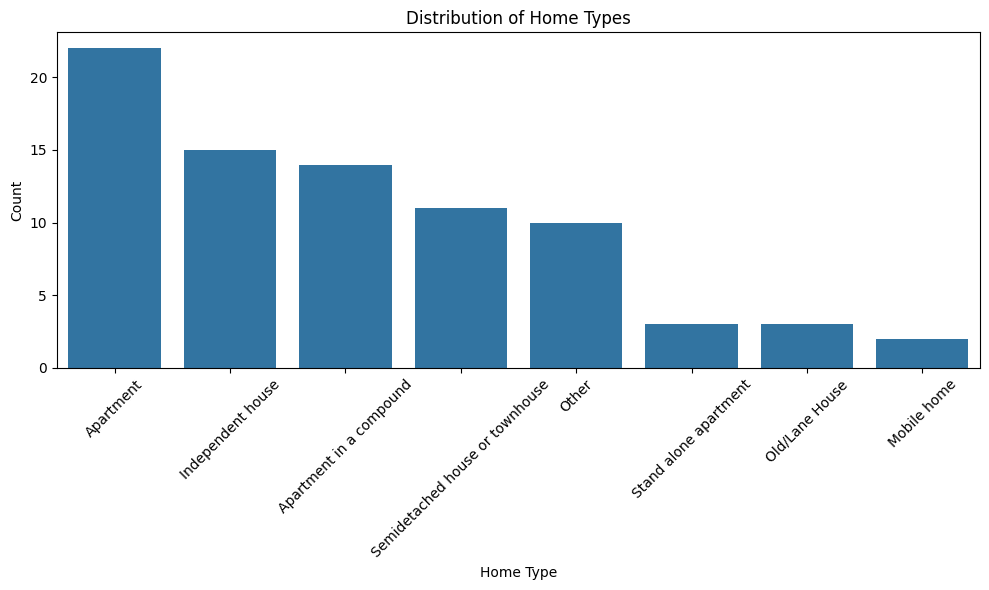

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping numerical values to home types
home_type_mapping_ID_NL_US = {
    1.: 'Apartment',
    2.: 'Semidetached house or townhouse',
    3.: 'Independent house',
    4.: 'Mobile home',
    97.: 'Other'
}
home_type_mapping_CN = {
    1.: 'Old/Lane House',
    2.: 'Stand alone apartment',
    3.: 'Apartment in a compound',
    4.: 'Villa',
    5.:	"Serviced Apartment",
    97.:	"Other",
    98.:	"Don't know"
}

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_ID_NL_US' with the provided mapping
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].map(home_type_mapping_ID_NL_US)

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_CN' with the provided mapping
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].map(home_type_mapping_CN)

# Fill NaN values in 'Q1_home_ID_NL_US' with the values from 'Q1_home_CN_mapped'
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].fillna(AllWave1['Q1_home_CN'])


# Visualise the distribution of home types
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', order=AllWave1['Q1_home_ID_NL_US'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

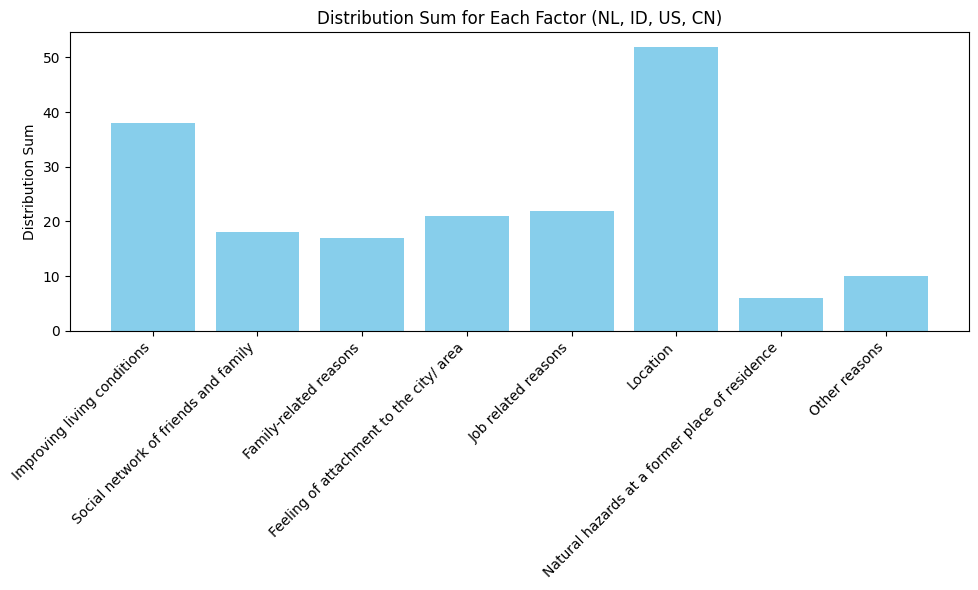

In [ ]:
# Calculate distribution sum for each factor
distribution_sums = []
factors = []

# Define mapping of response options to factors
factor_mapping = {
    'Improving living conditions': 'Q11_search_improve',
    'Social network of friends and family': 'Q11_search_social',
    'Family-related reasons': 'Q11_search_family',
    'Feeling of attachment to the city/ area': 'Q11_search_area',
    'Job related reasons': 'Q11_search_job',
    'Location': 'Q11_search_location',
    'Natural hazards at a former place of residence': 'Q11_search_hazard',
    'Other reasons': 'Q11_search_other',
}

for factor, column in factor_mapping.items():
    distribution_sum = AllWave1[column].sum()
    factors.append(factor)
    distribution_sums.append(distribution_sum)

# Create distribution plot
plt.figure(figsize=(10, 6))
plt.bar(factors, distribution_sums, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Distribution Sum')
plt.title('Distribution Sum for Each Factor (NL, ID, US, CN)')
plt.tight_layout()
plt.show()

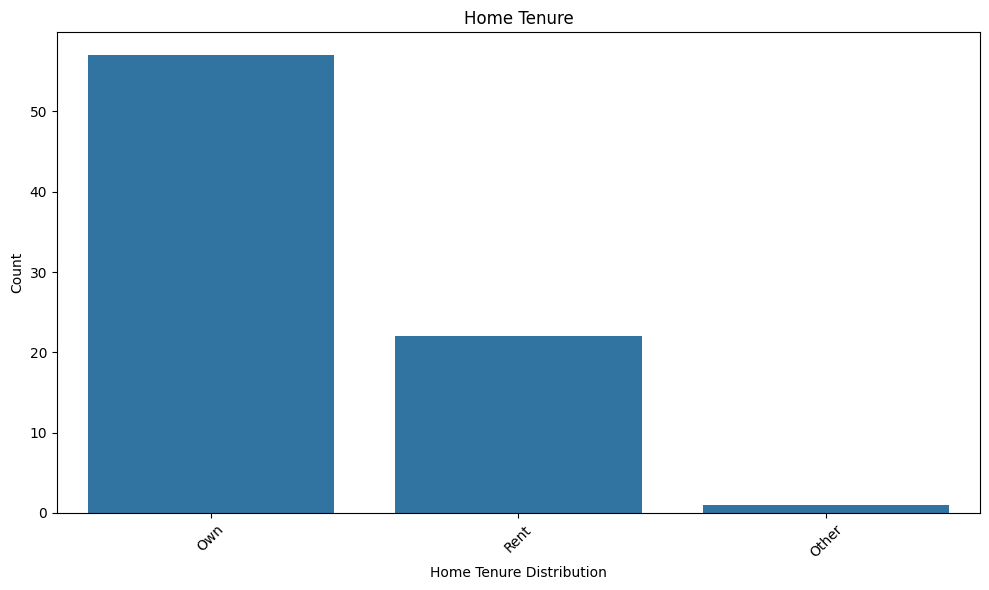

In [ ]:
# Mapping for home tenure
rent_own_mapping = {
    1: 'Rent',
    2: "Own",
    97: 'Other',
}

# Apply mapping
AllWave1['rent_own_mapping'] = AllWave1['Q5_home_tenure'].map(rent_own_mapping)

# Visualize the distribution of home tenure
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='rent_own_mapping', order=AllWave1['rent_own_mapping'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Home Tenure')
plt.xlabel('Home Tenure Distribution')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

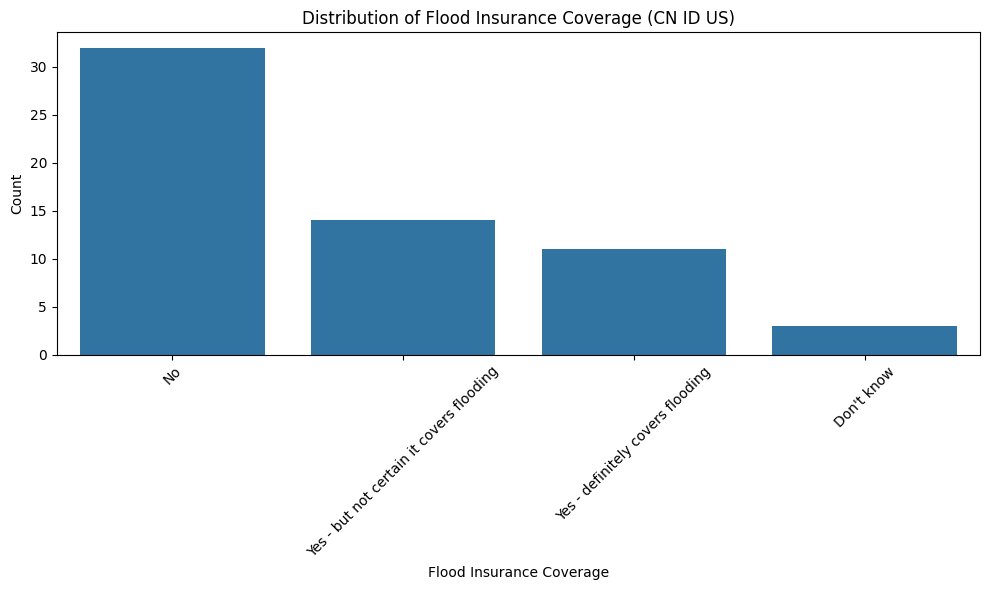

In [ ]:
# Mapping for flood insurance coverage
insurance_coverage_mapping = {
    1: 'Yes - definitely covers flooding',
    2: "Yes - but not certain it covers flooding",
    3: 'No',
    98: "Don't know"
}

# Apply mapping
AllWave1['insurance_coverage_mapped'] = AllWave1['Q41_ins_CN_ID_US'].map(insurance_coverage_mapping)

# Visualize the distribution of insurance coverage
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='insurance_coverage_mapped', order=AllWave1['insurance_coverage_mapped'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Flood Insurance Coverage (CN ID US)')
plt.xlabel('Flood Insurance Coverage')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

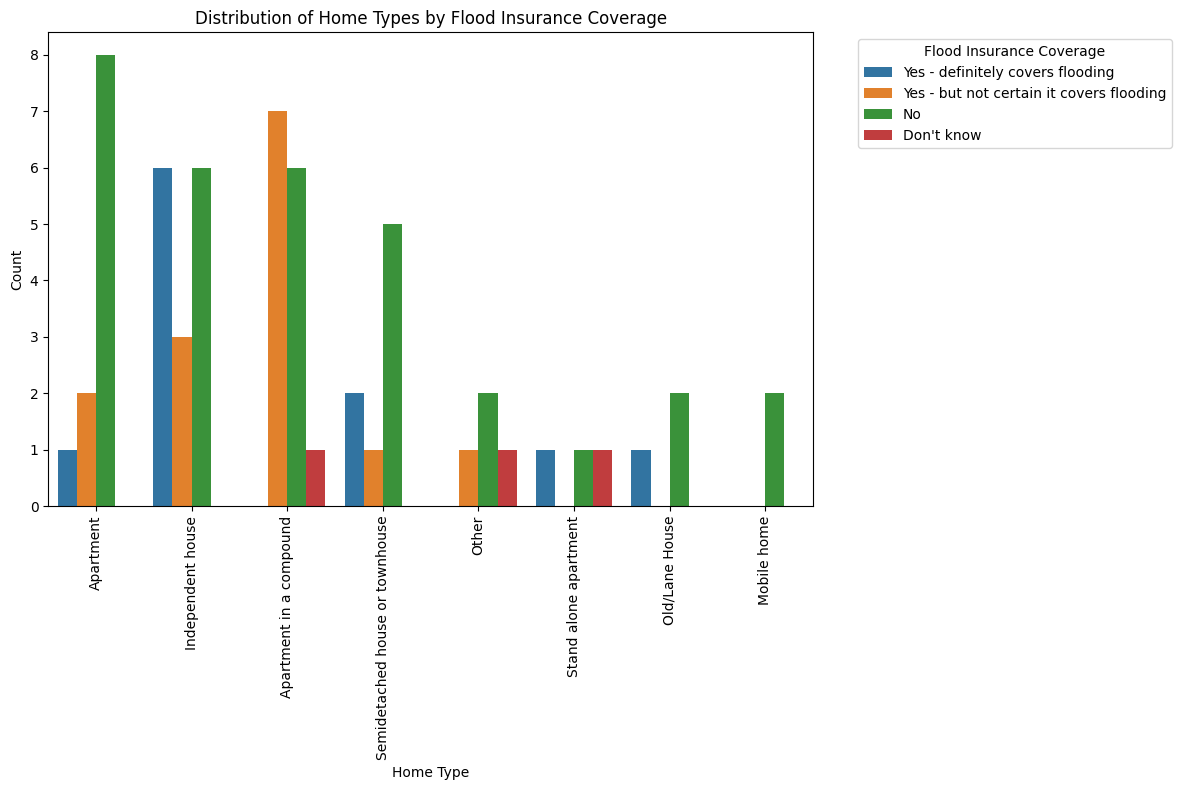

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', hue='insurance_coverage_mapped', 
              order=AllWave1['Q1_home_ID_NL_US'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Types by Flood Insurance Coverage')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


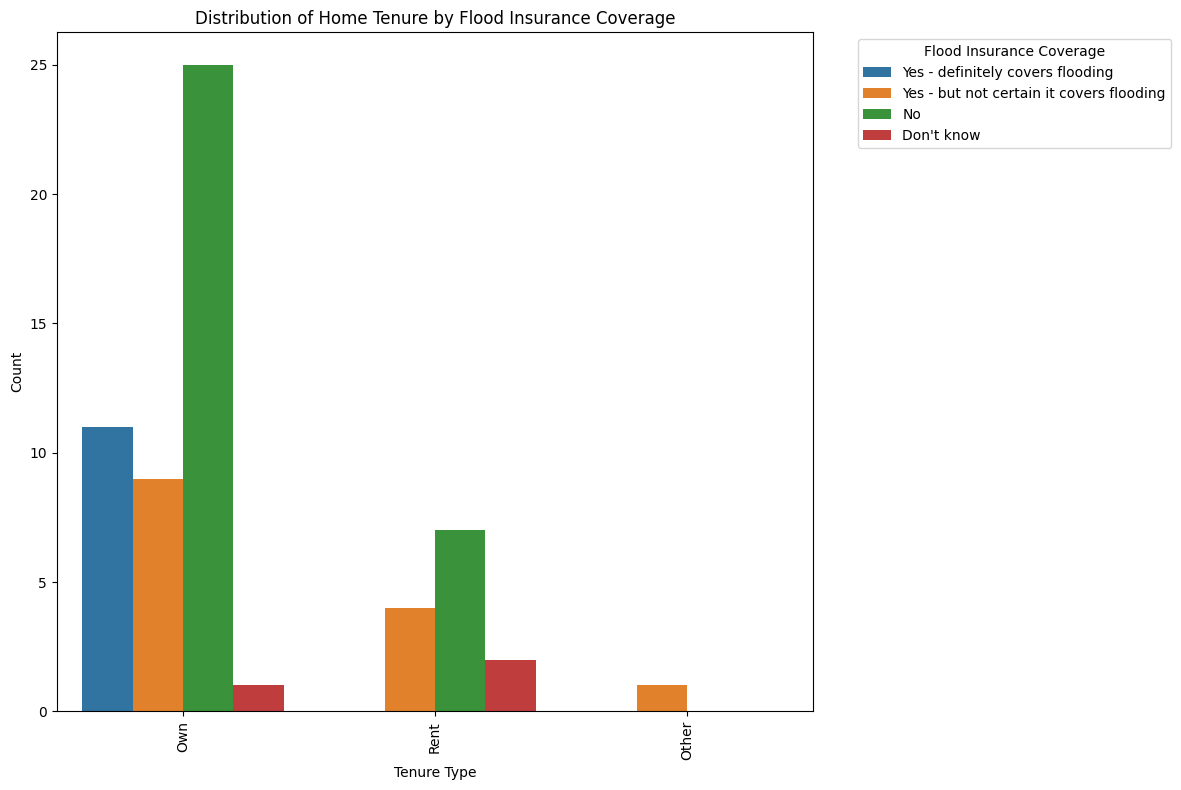

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='rent_own_mapping', hue='insurance_coverage_mapped', order=AllWave1['rent_own_mapping'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Tenure by Flood Insurance Coverage')
plt.xlabel('Tenure Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
correlation_data = AllWave1[["Q18_flood_exp", "R05_worry", "R2_implementation_NM4"]].copy()
# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix

,Q18_flood_exp,R05_worry,R2_implementation_NM4
Q18_flood_exp,1.000000,0.261944,-0.129233
R05_worry,0.261944,1.000000,-0.282069
R2_implementation_NM4,-0.129233,-0.282069,1.000000


In [ ]:
correlation_data = pd.DataFrame()
correlation_data['Q44_social_expectation'] = AllWave1['Q44_social_expectation'].copy()

# Create a new column that counts the occurrences of value == 1 in the specified columns
correlation_data['sum of household infrastructure change'] = AllWave1[['R2_implementation_SM1',
                                          'R2_implementation_SM2',
                                          'R2_implementation_SM3',
                                          'R2_implementation_SM4',
                                          'R2_implementation_SM5',
                                          'R2_implementation_SM6',
                                          'R2_implementation_SM7']].apply(lambda x: x.sum(), axis=1)

# Adjust 'Q41_ins_CN_ID_US' column based on the given condition
correlation_data['Intentional Flood insurance'] = AllWave1['Q41_ins_CN_ID_US'].apply(lambda x: 0 if x != 1 else x)

# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix


,Q44_social_expectation,sum of household infrastructure change,Intentional Flood insurance
Q44_social_expectation,1.000000,-0.397670,0.338019
sum of household infrastructure change,-0.397670,1.000000,-0.263891
Intentional Flood insurance,0.338019,-0.263891,1.000000
